# How to Train Your Own Key Points Detection Networks

![](https://user-images.githubusercontent.com/22118253/69765965-fd65a700-1143-11ea-8804-cd1d33f2e824.png)

In this notebook, we will demonstrate 
- how to train your own KeyPoints detection network and do inference on pictures of traffic cone.

**[Accurate Low Latency Visual Perception for Autonomous Racing: Challenges Mechanisms and Practical Solutions](https://github.com/mit-han-lab/once-for-all)** is an accurate low latency visual perception system introduced by Kieran Strobel, Sibo Zhu, Raphael Chang, and Skanda Koppula.


## 1. Preparation
Let's first install all the required packages:

In [1]:
! sudo apt install unzip
print('Installing numpy...')
! pip3 install numpy 
# tqdm is a package for displaying a progress bar.
print('Installing tqdm (progress bar) ...')
! pip3 install tqdm 
print('Installing matplotlib...')
! pip3 install matplotlib 
print('Installing dataset reader...')
! pip3 install pandas

Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-21ubuntu1).
The following packages were automatically installed and are no longer required:
  cuda-10-1 cuda-command-line-tools-10-1 cuda-compiler-10-1 cuda-cudart-10-1
  cuda-cudart-dev-10-1 cuda-cufft-10-1 cuda-cufft-dev-10-1 cuda-cuobjdump-10-1
  cuda-cupti-10-1 cuda-curand-10-1 cuda-curand-dev-10-1 cuda-cusolver-10-1
  cuda-cusolver-dev-10-1 cuda-cusparse-10-1 cuda-cusparse-dev-10-1
  cuda-demo-suite-10-1 cuda-documentation-10-1 cuda-driver-dev-10-1
  cuda-gdb-10-1 cuda-gpu-library-advisor-10-1 cuda-libraries-10-1
  cuda-libraries-dev-10-1 cuda-license-10-1 cuda-memcheck-10-1
  cuda-misc-headers-10-1 cuda-npp-10-1 cuda-npp-dev-10-1 cuda-nsight-10-1
  cuda-nsight-compute-10-1 cuda-nsight-systems-10-1 cuda-nvcc-10-1
  cuda-nvdisasm-10-1 cuda-nvgraph-10-1 cuda-nvgraph-dev-10-1 cuda-nvjpeg-10-1
  cuda-nvjpeg-dev-10-1 cuda-nvml-dev-10-1 cuda-nvprof-10-

Before we start training, let's download the Cone Detection dataset and the corresponding label and intial training weights. 

In [2]:
print("Downloading Training Dataset")
! wget https://storage.googleapis.com/mit-driverless-open-source/RektNet_Dataset.zip
! unzip RektNet_Dataset.zip
! mv RektNet_Dataset dataset/ && rm RektNet_Dataset.zip
print("Downloading Training and Validation Label")
! cd dataset/ && wget https://storage.googleapis.com/mit-driverless-open-source/rektnet-training/rektnet_label.csv && cd ..

--2020-08-25 13:28:46--  https://storage.googleapis.com/mit-driverless-open-source/RektNet_Dataset.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.196.128, 74.125.124.128, 172.217.212.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.196.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 82108587 (78M) [application/zip]
Saving to: ‘RektNet_Dataset.zip’

RektNet_Dataset.zip 100%[===================>]  78.30M   137MB/s    in 0.6s    

2020-08-25 13:28:47 (137 MB/s) - ‘RektNet_Dataset.zip’ saved [82108587/82108587]

Archive:  RektNet_Dataset.zip
   creating: RektNet_Dataset/
  inflating: RektNet_Dataset/vid_30_frame_2342_3.jpg  
  inflating: RektNet_Dataset/vid_42_frame_773_13.jpg  
  inflating: RektNet_Dataset/vid_37_frame_736_19.jpg  
  inflating: RektNet_Dataset/vid_31_frame_1779_6.jpg  
  inflating: RektNet_Dataset/vid_78_frame_283_1.jpg  
  inflating: RektNet_Dataset/vid_31_frame_1846_1.jpg  
  inflating

  inflating: RektNet_Dataset/vid_42_frame_219_0.jpg  
  inflating: RektNet_Dataset/vid_30_frame_1461_0.jpg  
  inflating: RektNet_Dataset/vid_31_frame_3166_1.jpg  
  inflating: RektNet_Dataset/vid_31_frame_2388_16.jpg  
  inflating: RektNet_Dataset/vid_31_frame_3076_3.jpg  
  inflating: RektNet_Dataset/vid_42_frame_556_3.jpg  
  inflating: RektNet_Dataset/vid_3_frame_37022_4.jpg  
  inflating: RektNet_Dataset/vid_41_frame_640_39.jpg  
  inflating: RektNet_Dataset/vid_5_frame_2125_4.jpg  
  inflating: RektNet_Dataset/vid_40_frame_1138_13.jpg  
  inflating: RektNet_Dataset/vid_123_frame_6550_6.jpg  
  inflating: RektNet_Dataset/vid_37_frame_309_0.jpg  
  inflating: RektNet_Dataset/vid_38_frame_327_23.jpg  
  inflating: RektNet_Dataset/vid_5_frame_2209_1.jpg  
  inflating: RektNet_Dataset/vid_83_frame_111_2.jpg  
  inflating: RektNet_Dataset/vid_220_frame_145_4.jpg  
  inflating: RektNet_Dataset/vid_28_frame_2127_1.jpg  
  inflating: RektNet_Dataset/vid_31_frame_2132_20.jpg  
  inflating:

  inflating: RektNet_Dataset/vid_3_frame_9144_3.jpg  
  inflating: RektNet_Dataset/vid_31_frame_2903_9.jpg  
  inflating: RektNet_Dataset/vid_30_frame_1352_7.jpg  
  inflating: RektNet_Dataset/vid_42_frame_154_2.jpg  
  inflating: RektNet_Dataset/vid_40_frame_548_10.jpg  
  inflating: RektNet_Dataset/vid_82_frame_68_8.jpg  
  inflating: RektNet_Dataset/vid_56_frame_178_4.jpg  
  inflating: RektNet_Dataset/vid_40_frame_1081_8.jpg  
  inflating: RektNet_Dataset/vid_31_frame_2894_10.jpg  
  inflating: RektNet_Dataset/vid_28_frame_1649_0.jpg  
  inflating: RektNet_Dataset/vid_31_frame_1518_9.jpg  
  inflating: RektNet_Dataset/vid_41_frame_810_25.jpg  
  inflating: RektNet_Dataset/vid_2_frame_9992_0.jpg  
  inflating: RektNet_Dataset/vid_38_frame_745_1.jpg  
  inflating: RektNet_Dataset/vid_5_frame_2062_1.jpg  
  inflating: RektNet_Dataset/vid_45_frame_491_14.jpg  
  inflating: RektNet_Dataset/vid_37_frame_400_0.jpg  
  inflating: RektNet_Dataset/vid_5_frame_2514_11.jpg  
  inflating: RektN

  inflating: RektNet_Dataset/vid_18_frame_2267_8.jpg  
  inflating: RektNet_Dataset/vid_5_frame_1566_9.jpg  
  inflating: RektNet_Dataset/vid_31_frame_2554_0.jpg  
  inflating: RektNet_Dataset/vid_28_frame_1673_9.jpg  
  inflating: RektNet_Dataset/vid_31_frame_2882_0.jpg  
  inflating: RektNet_Dataset/vid_37_frame_461_7.jpg  
  inflating: RektNet_Dataset/vid_36_frame_372_5.jpg  
  inflating: RektNet_Dataset/vid_3_frame_3050_4.jpg  
  inflating: RektNet_Dataset/vid_5_frame_2145_5.jpg  
  inflating: RektNet_Dataset/vid_31_frame_2375_1.jpg  
  inflating: RektNet_Dataset/vid_40_frame_1287_11.jpg  
  inflating: RektNet_Dataset/vid_40_frame_86_4.jpg  
  inflating: RektNet_Dataset/vid_31_frame_2232_10.jpg  
  inflating: RektNet_Dataset/vid_5_frame_2158_5.jpg  
  inflating: RektNet_Dataset/vid_40_frame_651_4.jpg  
  inflating: RektNet_Dataset/vid_3_frame_28995_0.jpg  
  inflating: RektNet_Dataset/vid_101_frame_115_16.jpg  
  inflating: RektNet_Dataset/vid_40_frame_758_13.jpg  
  inflating: Rek

  inflating: RektNet_Dataset/vid_31_frame_1652_3.jpg  
  inflating: RektNet_Dataset/vid_31_frame_3028_0.jpg  
  inflating: RektNet_Dataset/vid_18_frame_1931_3.jpg  
  inflating: RektNet_Dataset/vid_36_frame_355_5.jpg  
  inflating: RektNet_Dataset/vid_71_frame_248_4.jpg  
  inflating: RektNet_Dataset/vid_31_frame_2446_4.jpg  
  inflating: RektNet_Dataset/vid_31_frame_2128_9.jpg  
  inflating: RektNet_Dataset/vid_123_frame_9506_5.jpg  
  inflating: RektNet_Dataset/vid_31_frame_1540_3.jpg  
  inflating: RektNet_Dataset/vid_40_frame_510_2.jpg  
  inflating: RektNet_Dataset/vid_36_frame_264_0.jpg  
  inflating: RektNet_Dataset/vid_42_frame_776_6.jpg  
  inflating: RektNet_Dataset/vid_3_frame_19000_0.jpg  
  inflating: RektNet_Dataset/vid_45_frame_299_19.jpg  
  inflating: RektNet_Dataset/vid_42_frame_233_17.jpg  
  inflating: RektNet_Dataset/vid_30_frame_1358_3.jpg  
  inflating: RektNet_Dataset/vid_31_frame_2143_3.jpg  
  inflating: RektNet_Dataset/vid_31_frame_1594_9.jpg  
  inflating: R

  inflating: RektNet_Dataset/vid_31_frame_3062_3.jpg  
  inflating: RektNet_Dataset/vid_40_frame_217_13.jpg  
  inflating: RektNet_Dataset/vid_31_frame_2220_1.jpg  
  inflating: RektNet_Dataset/vid_2_frame_4223_4.jpg  
  inflating: RektNet_Dataset/vid_31_frame_2256_1.jpg  
  inflating: RektNet_Dataset/vid_28_frame_1673_5.jpg  
  inflating: RektNet_Dataset/vid_40_frame_556_4.jpg  
  inflating: RektNet_Dataset/vid_5_frame_1580_5.jpg  
  inflating: RektNet_Dataset/vid_42_frame_730_7.jpg  
  inflating: RektNet_Dataset/vid_38_frame_467_7.jpg  
  inflating: RektNet_Dataset/vid_109_frame_8_10.jpg  
  inflating: RektNet_Dataset/vid_31_frame_2533_1.jpg  
  inflating: RektNet_Dataset/vid_37_frame_579_16.jpg  
  inflating: RektNet_Dataset/vid_38_frame_177_10.jpg  
  inflating: RektNet_Dataset/vid_37_frame_357_11.jpg  
  inflating: RektNet_Dataset/vid_41_frame_415_14.jpg  
  inflating: RektNet_Dataset/vid_40_frame_1075_10.jpg  
  inflating: RektNet_Dataset/vid_3_frame_31926_6.jpg  
  inflating: Re

  inflating: RektNet_Dataset/vid_224_frame_2_3.jpg  
  inflating: RektNet_Dataset/vid_28_frame_2170_3.jpg  
  inflating: RektNet_Dataset/vid_18_frame_1597_0.jpg  
  inflating: RektNet_Dataset/vid_31_frame_3149_7.jpg  
  inflating: RektNet_Dataset/vid_28_frame_1282_2.jpg  
  inflating: RektNet_Dataset/vid_42_frame_1012_4.jpg  
  inflating: RektNet_Dataset/vid_2_frame_20957_9.jpg  
  inflating: RektNet_Dataset/vid_2_frame_24838_4.jpg  
  inflating: RektNet_Dataset/vid_30_frame_2610_3.jpg  
  inflating: RektNet_Dataset/vid_38_frame_672_11.jpg  
  inflating: RektNet_Dataset/vid_73_frame_206_7.jpg  
  inflating: RektNet_Dataset/vid_30_frame_1583_6.jpg  
  inflating: RektNet_Dataset/vid_30_frame_2219_1.jpg  
  inflating: RektNet_Dataset/vid_40_frame_1287_20.jpg  
  inflating: RektNet_Dataset/vid_38_frame_913_26.jpg  
  inflating: RektNet_Dataset/vid_38_frame_250_25.jpg  
  inflating: RektNet_Dataset/vid_37_frame_747_6.jpg  
  inflating: RektNet_Dataset/vid_88_frame_252_10.jpg  
  inflating: 

  inflating: RektNet_Dataset/vid_42_frame_958_5.jpg  
  inflating: RektNet_Dataset/vid_41_frame_156_8.jpg  
  inflating: RektNet_Dataset/vid_28_frame_2439_9.jpg  
  inflating: RektNet_Dataset/vid_38_frame_636_9.jpg  
  inflating: RektNet_Dataset/vid_40_frame_1365_4.jpg  
  inflating: RektNet_Dataset/vid_104_frame_232_0.jpg  
  inflating: RektNet_Dataset/vid_107_frame_33_10.jpg  
  inflating: RektNet_Dataset/vid_37_frame_521_22.jpg  
  inflating: RektNet_Dataset/vid_2_frame_16816_9.jpg  
  inflating: RektNet_Dataset/vid_38_frame_213_6.jpg  
  inflating: RektNet_Dataset/vid_40_frame_1267_8.jpg  
  inflating: RektNet_Dataset/vid_79_frame_43_7.jpg  
  inflating: RektNet_Dataset/vid_28_frame_2392_1.jpg  
  inflating: RektNet_Dataset/vid_101_frame_136_23.jpg  
  inflating: RektNet_Dataset/vid_31_frame_1692_9.jpg  
  inflating: RektNet_Dataset/vid_28_frame_1659_3.jpg  
  inflating: RektNet_Dataset/vid_5_frame_1384_0.jpg  
  inflating: RektNet_Dataset/vid_28_frame_2465_3.jpg  
  inflating: Rek

  inflating: RektNet_Dataset/vid_5_frame_1870_0.jpg  
  inflating: RektNet_Dataset/vid_36_frame_243_3.jpg  
  inflating: RektNet_Dataset/vid_41_frame_415_7.jpg  
  inflating: RektNet_Dataset/vid_97_frame_334_4.jpg  
  inflating: RektNet_Dataset/vid_2_frame_28663_3.jpg  
  inflating: RektNet_Dataset/vid_2_frame_7983_2.jpg  
  inflating: RektNet_Dataset/vid_2_frame_42242_7.jpg  
  inflating: RektNet_Dataset/vid_31_frame_1899_3.jpg  
  inflating: RektNet_Dataset/vid_77_frame_256_1.jpg  
  inflating: RektNet_Dataset/vid_45_frame_425_0.jpg  
  inflating: RektNet_Dataset/vid_31_frame_2694_5.jpg  
  inflating: RektNet_Dataset/vid_28_frame_1180_5.jpg  
  inflating: RektNet_Dataset/vid_45_frame_606_2.jpg  
  inflating: RektNet_Dataset/vid_31_frame_1797_0.jpg  
  inflating: RektNet_Dataset/vid_31_frame_2761_8.jpg  
  inflating: RektNet_Dataset/vid_101_frame_100_10.jpg  
  inflating: RektNet_Dataset/vid_84_frame_10_5.jpg  
  inflating: RektNet_Dataset/vid_31_frame_3167_6.jpg  
  inflating: RektNe

  inflating: RektNet_Dataset/vid_40_frame_243_22.jpg  
  inflating: RektNet_Dataset/vid_18_frame_2261_4.jpg  
  inflating: RektNet_Dataset/vid_30_frame_2605_4.jpg  
  inflating: RektNet_Dataset/vid_45_frame_616_16.jpg  
  inflating: RektNet_Dataset/vid_42_frame_378_22.jpg  
  inflating: RektNet_Dataset/vid_38_frame_182_20.jpg  
  inflating: RektNet_Dataset/vid_40_frame_369_5.jpg  
  inflating: RektNet_Dataset/vid_2_frame_41341_6.jpg  
  inflating: RektNet_Dataset/vid_38_frame_902_3.jpg  
  inflating: RektNet_Dataset/vid_40_frame_74_11.jpg  
  inflating: RektNet_Dataset/vid_6_frame_32296_4.jpg  
  inflating: RektNet_Dataset/vid_31_frame_3203_3.jpg  
  inflating: RektNet_Dataset/vid_42_frame_887_5.jpg  
  inflating: RektNet_Dataset/vid_37_frame_700_0.jpg  
  inflating: RektNet_Dataset/vid_5_frame_2272_2.jpg  
  inflating: RektNet_Dataset/vid_38_frame_68_6.jpg  
  inflating: RektNet_Dataset/vid_5_frame_1794_1.jpg  
  inflating: RektNet_Dataset/vid_5_frame_1555_9.jpg  
  inflating: RektNet

  inflating: RektNet_Dataset/vid_41_frame_817_4.jpg  
  inflating: RektNet_Dataset/vid_38_frame_566_17.jpg  
  inflating: RektNet_Dataset/vid_31_frame_2586_4.jpg  
  inflating: RektNet_Dataset/vid_40_frame_292_13.jpg  
  inflating: RektNet_Dataset/vid_2_frame_26468_9.jpg  
  inflating: RektNet_Dataset/vid_105_frame_100_2.jpg  
  inflating: RektNet_Dataset/vid_6_frame_16611_3.jpg  
  inflating: RektNet_Dataset/vid_2_frame_37165_0.jpg  
  inflating: RektNet_Dataset/vid_18_frame_1566_2.jpg  
  inflating: RektNet_Dataset/vid_40_frame_578_3.jpg  
  inflating: RektNet_Dataset/vid_5_frame_1829_0.jpg  
  inflating: RektNet_Dataset/vid_2_frame_31279_1.jpg  
  inflating: RektNet_Dataset/vid_67_frame_217_0.jpg  
  inflating: RektNet_Dataset/vid_30_frame_1627_4.jpg  
  inflating: RektNet_Dataset/vid_5_frame_1661_6.jpg  
  inflating: RektNet_Dataset/vid_31_frame_1959_1.jpg  
  inflating: RektNet_Dataset/vid_31_frame_1707_0.jpg  
  inflating: RektNet_Dataset/vid_38_frame_460_8.jpg  
  inflating: Rek

  inflating: RektNet_Dataset/vid_42_frame_571_22.jpg  
  inflating: RektNet_Dataset/vid_101_frame_176_27.jpg  
  inflating: RektNet_Dataset/vid_5_frame_1338_8.jpg  
  inflating: RektNet_Dataset/vid_101_frame_61_21.jpg  
  inflating: RektNet_Dataset/vid_2_frame_31752_2.jpg  
  inflating: RektNet_Dataset/vid_37_frame_210_8.jpg  
  inflating: RektNet_Dataset/vid_18_frame_1151_0.jpg  
  inflating: RektNet_Dataset/vid_2_frame_6924_4.jpg  
  inflating: RektNet_Dataset/vid_2_frame_21016_4.jpg  
  inflating: RektNet_Dataset/vid_42_frame_482_14.jpg  
  inflating: RektNet_Dataset/vid_30_frame_1855_1.jpg  
  inflating: RektNet_Dataset/vid_5_frame_1433_1.jpg  
  inflating: RektNet_Dataset/vid_5_frame_2339_3.jpg  
  inflating: RektNet_Dataset/vid_45_frame_853_5.jpg  
  inflating: RektNet_Dataset/vid_42_frame_482_17.jpg  
  inflating: RektNet_Dataset/vid_38_frame_793_5.jpg  
  inflating: RektNet_Dataset/vid_40_frame_1032_4.jpg  
  inflating: RektNet_Dataset/vid_38_frame_930_13.jpg  
  inflating: Rek

  inflating: RektNet_Dataset/vid_41_frame_115_1.jpg  
  inflating: RektNet_Dataset/vid_42_frame_651_1.jpg  
  inflating: RektNet_Dataset/vid_38_frame_699_4.jpg  
  inflating: RektNet_Dataset/vid_45_frame_606_7.jpg  
  inflating: RektNet_Dataset/vid_36_frame_341_3.jpg  
  inflating: RektNet_Dataset/vid_108_frame_459_1.jpg  
  inflating: RektNet_Dataset/vid_76_frame_26_6.jpg  
  inflating: RektNet_Dataset/vid_5_frame_1690_3.jpg  
  inflating: RektNet_Dataset/vid_3_frame_26299_6.jpg  
  inflating: RektNet_Dataset/vid_31_frame_2641_4.jpg  
  inflating: RektNet_Dataset/vid_79_frame_98_9.jpg  
  inflating: RektNet_Dataset/vid_203_frame_33_0.jpg  
  inflating: RektNet_Dataset/vid_3_frame_26299_3.jpg  
  inflating: RektNet_Dataset/vid_38_frame_334_6.jpg  
  inflating: RektNet_Dataset/vid_80_frame_41_2.jpg  
  inflating: RektNet_Dataset/vid_213_frame_32_4.jpg  
  inflating: RektNet_Dataset/vid_5_frame_1373_6.jpg  
  inflating: RektNet_Dataset/vid_40_frame_795_10.jpg  
  inflating: RektNet_Datas

  inflating: RektNet_Dataset/vid_38_frame_957_5.jpg  
  inflating: RektNet_Dataset/vid_31_frame_3190_2.jpg  
  inflating: RektNet_Dataset/vid_56_frame_70_2.jpg  
  inflating: RektNet_Dataset/vid_83_frame_111_1.jpg  
  inflating: RektNet_Dataset/vid_40_frame_1357_7.jpg  
  inflating: RektNet_Dataset/vid_42_frame_267_6.jpg  
  inflating: RektNet_Dataset/vid_40_frame_219_22.jpg  
  inflating: RektNet_Dataset/vid_42_frame_716_6.jpg  
  inflating: RektNet_Dataset/vid_45_frame_857_7.jpg  
  inflating: RektNet_Dataset/vid_45_frame_882_0.jpg  
  inflating: RektNet_Dataset/vid_41_frame_372_13.jpg  
  inflating: RektNet_Dataset/vid_37_frame_681_10.jpg  
  inflating: RektNet_Dataset/vid_31_frame_2736_1.jpg  
  inflating: RektNet_Dataset/vid_18_frame_1842_4.jpg  
  inflating: RektNet_Dataset/vid_38_frame_793_27.jpg  
  inflating: RektNet_Dataset/vid_40_frame_279_1.jpg  
  inflating: RektNet_Dataset/vid_38_frame_883_13.jpg  
  inflating: RektNet_Dataset/vid_41_frame_388_8.jpg  
  inflating: RektNet

  inflating: RektNet_Dataset/vid_28_frame_2455_5.jpg  
  inflating: RektNet_Dataset/vid_40_frame_1291_13.jpg  
  inflating: RektNet_Dataset/vid_41_frame_624_0.jpg  
  inflating: RektNet_Dataset/vid_28_frame_2590_3.jpg  
  inflating: RektNet_Dataset/vid_41_frame_758_5.jpg  
  inflating: RektNet_Dataset/vid_31_frame_2003_2.jpg  
  inflating: RektNet_Dataset/vid_37_frame_285_15.jpg  
  inflating: RektNet_Dataset/vid_40_frame_907_3.jpg  
  inflating: RektNet_Dataset/vid_2_frame_34406_5.jpg  
  inflating: RektNet_Dataset/vid_36_frame_210_5.jpg  
  inflating: RektNet_Dataset/vid_78_frame_10_9.jpg  
  inflating: RektNet_Dataset/vid_38_frame_250_1.jpg  
  inflating: RektNet_Dataset/vid_121_frame_9273_5.jpg  
  inflating: RektNet_Dataset/vid_200_frame_148_0.jpg  
  inflating: RektNet_Dataset/vid_38_frame_539_1.jpg  
  inflating: RektNet_Dataset/vid_31_frame_1670_3.jpg  
  inflating: RektNet_Dataset/vid_2_frame_42101_4.jpg  
  inflating: RektNet_Dataset/vid_31_frame_3150_6.jpg  
  inflating: Rek

  inflating: RektNet_Dataset/vid_31_frame_2381_8.jpg  
  inflating: RektNet_Dataset/vid_64_frame_709_1.jpg  
  inflating: RektNet_Dataset/vid_3_frame_2554_1.jpg  
  inflating: RektNet_Dataset/vid_31_frame_2084_2.jpg  
  inflating: RektNet_Dataset/vid_42_frame_556_8.jpg  
  inflating: RektNet_Dataset/vid_78_frame_10_16.jpg  
  inflating: RektNet_Dataset/vid_40_frame_581_6.jpg  
  inflating: RektNet_Dataset/vid_31_frame_2483_1.jpg  
  inflating: RektNet_Dataset/vid_30_frame_2379_7.jpg  
  inflating: RektNet_Dataset/vid_91_frame_149_2.jpg  
  inflating: RektNet_Dataset/vid_40_frame_161_12.jpg  
  inflating: RektNet_Dataset/vid_28_frame_1921_7.jpg  
  inflating: RektNet_Dataset/vid_5_frame_1438_2.jpg  
  inflating: RektNet_Dataset/vid_42_frame_488_4.jpg  
  inflating: RektNet_Dataset/vid_31_frame_3017_5.jpg  
  inflating: RektNet_Dataset/vid_41_frame_859_6.jpg  
  inflating: RektNet_Dataset/vid_36_frame_65_4.jpg  
  inflating: RektNet_Dataset/vid_37_frame_728_37.jpg  
  inflating: RektNet_

  inflating: RektNet_Dataset/vid_30_frame_1774_0.jpg  
  inflating: RektNet_Dataset/vid_38_frame_423_13.jpg  
  inflating: RektNet_Dataset/vid_5_frame_2534_2.jpg  
  inflating: RektNet_Dataset/vid_31_frame_1787_4.jpg  
  inflating: RektNet_Dataset/vid_40_frame_1017_9.jpg  
  inflating: RektNet_Dataset/vid_31_frame_2623_8.jpg  
  inflating: RektNet_Dataset/vid_217_frame_112_3.jpg  
  inflating: RektNet_Dataset/vid_31_frame_3185_3.jpg  
  inflating: RektNet_Dataset/vid_2_frame_16108_4.jpg  
  inflating: RektNet_Dataset/vid_31_frame_1598_3.jpg  
  inflating: RektNet_Dataset/vid_37_frame_174_11.jpg  
  inflating: RektNet_Dataset/vid_2_frame_19823_0.jpg  
  inflating: RektNet_Dataset/vid_40_frame_991_7.jpg  
  inflating: RektNet_Dataset/vid_5_frame_1415_6.jpg  
  inflating: RektNet_Dataset/vid_70_frame_44_1.jpg  
  inflating: RektNet_Dataset/vid_3_frame_8594_3.jpg  
  inflating: RektNet_Dataset/vid_65_frame_26_14.jpg  
  inflating: RektNet_Dataset/vid_42_frame_927_8.jpg  
  inflating: RektN

  inflating: RektNet_Dataset/vid_41_frame_454_14.jpg  
  inflating: RektNet_Dataset/vid_38_frame_390_7.jpg  
  inflating: RektNet_Dataset/vid_28_frame_1888_3.jpg  
  inflating: RektNet_Dataset/vid_64_frame_577_9.jpg  
  inflating: RektNet_Dataset/vid_40_frame_563_7.jpg  
  inflating: RektNet_Dataset/vid_37_frame_255_9.jpg  
  inflating: RektNet_Dataset/vid_42_frame_194_23.jpg  
  inflating: RektNet_Dataset/vid_37_frame_252_3.jpg  
  inflating: RektNet_Dataset/vid_31_frame_3025_2.jpg  
  inflating: RektNet_Dataset/vid_37_frame_521_15.jpg  
  inflating: RektNet_Dataset/vid_3_frame_15904_2.jpg  
  inflating: RektNet_Dataset/vid_28_frame_1715_0.jpg  
  inflating: RektNet_Dataset/vid_45_frame_708_1.jpg  
  inflating: RektNet_Dataset/vid_40_frame_623_8.jpg  
  inflating: RektNet_Dataset/vid_18_frame_2033_3.jpg  
  inflating: RektNet_Dataset/vid_5_frame_1869_1.jpg  
  inflating: RektNet_Dataset/vid_45_frame_636_11.jpg  
  inflating: RektNet_Dataset/vid_6_frame_41028_2.jpg  
  inflating: RektN

  inflating: RektNet_Dataset/vid_38_frame_287_13.jpg  
  inflating: RektNet_Dataset/vid_37_frame_552_5.jpg  
  inflating: RektNet_Dataset/vid_42_frame_347_10.jpg  
  inflating: RektNet_Dataset/vid_38_frame_153_19.jpg  
  inflating: RektNet_Dataset/vid_45_frame_845_6.jpg  
  inflating: RektNet_Dataset/vid_42_frame_824_21.jpg  
  inflating: RektNet_Dataset/vid_42_frame_480_5.jpg  
  inflating: RektNet_Dataset/vid_38_frame_337_4.jpg  
  inflating: RektNet_Dataset/vid_40_frame_1231_11.jpg  
  inflating: RektNet_Dataset/vid_40_frame_103_19.jpg  
  inflating: RektNet_Dataset/vid_38_frame_177_8.jpg  
  inflating: RektNet_Dataset/vid_45_frame_302_10.jpg  
  inflating: RektNet_Dataset/vid_41_frame_643_34.jpg  
  inflating: RektNet_Dataset/vid_88_frame_252_5.jpg  
  inflating: RektNet_Dataset/vid_42_frame_359_12.jpg  
  inflating: RektNet_Dataset/vid_31_frame_2096_0.jpg  
  inflating: RektNet_Dataset/vid_45_frame_629_10.jpg  
  inflating: RektNet_Dataset/vid_78_frame_208_5.jpg  
  inflating: Rek

  inflating: RektNet_Dataset/vid_64_frame_400_2.jpg  
  inflating: RektNet_Dataset/vid_31_frame_1956_0.jpg  
  inflating: RektNet_Dataset/vid_3_frame_31924_1.jpg  
  inflating: RektNet_Dataset/vid_31_frame_2374_10.jpg  
  inflating: RektNet_Dataset/vid_5_frame_2020_7.jpg  
  inflating: RektNet_Dataset/vid_41_frame_643_18.jpg  
  inflating: RektNet_Dataset/vid_3_frame_39108_4.jpg  
  inflating: RektNet_Dataset/vid_31_frame_2079_0.jpg  
  inflating: RektNet_Dataset/vid_38_frame_975_6.jpg  
  inflating: RektNet_Dataset/vid_31_frame_2969_3.jpg  
  inflating: RektNet_Dataset/vid_45_frame_505_8.jpg  
  inflating: RektNet_Dataset/vid_41_frame_430_2.jpg  
  inflating: RektNet_Dataset/vid_31_frame_2224_1.jpg  
  inflating: RektNet_Dataset/vid_31_frame_2590_6.jpg  
  inflating: RektNet_Dataset/vid_40_frame_1223_11.jpg  
  inflating: RektNet_Dataset/vid_30_frame_1786_5.jpg  
  inflating: RektNet_Dataset/vid_18_frame_2250_7.jpg  
  inflating: RektNet_Dataset/vid_2_frame_33499_0.jpg  
  inflating: 

  inflating: RektNet_Dataset/vid_42_frame_576_3.jpg  
  inflating: RektNet_Dataset/vid_31_frame_2763_2.jpg  
  inflating: RektNet_Dataset/vid_41_frame_291_2.jpg  
  inflating: RektNet_Dataset/vid_31_frame_2017_1.jpg  
  inflating: RektNet_Dataset/vid_18_frame_2149_0.jpg  
  inflating: RektNet_Dataset/vid_38_frame_687_2.jpg  
  inflating: RektNet_Dataset/vid_37_frame_670_0.jpg  
  inflating: RektNet_Dataset/vid_40_frame_480_2.jpg  
  inflating: RektNet_Dataset/vid_38_frame_162_2.jpg  
  inflating: RektNet_Dataset/vid_2_frame_14539_11.jpg  
  inflating: RektNet_Dataset/vid_6_frame_16445_0.jpg  
  inflating: RektNet_Dataset/vid_37_frame_114_8.jpg  
  inflating: RektNet_Dataset/vid_31_frame_1532_2.jpg  
  inflating: RektNet_Dataset/vid_38_frame_907_22.jpg  
  inflating: RektNet_Dataset/vid_123_frame_7046_2.jpg  
  inflating: RektNet_Dataset/vid_5_frame_1999_7.jpg  
  inflating: RektNet_Dataset/vid_18_frame_2010_3.jpg  
  inflating: RektNet_Dataset/vid_45_frame_596_11.jpg  
  inflating: Rek

  inflating: RektNet_Dataset/vid_5_frame_1684_0.jpg  
  inflating: RektNet_Dataset/vid_42_frame_480_10.jpg  
  inflating: RektNet_Dataset/vid_18_frame_1495_11.jpg  
  inflating: RektNet_Dataset/vid_5_frame_1538_7.jpg  
  inflating: RektNet_Dataset/vid_40_frame_578_27.jpg  
  inflating: RektNet_Dataset/vid_31_frame_2807_3.jpg  
  inflating: RektNet_Dataset/vid_28_frame_1355_9.jpg  
  inflating: RektNet_Dataset/vid_112_frame_208_3.jpg  
  inflating: RektNet_Dataset/vid_42_frame_512_0.jpg  
  inflating: RektNet_Dataset/vid_3_frame_22413_9.jpg  
  inflating: RektNet_Dataset/vid_37_frame_346_32.jpg  
  inflating: RektNet_Dataset/vid_45_frame_833_2.jpg  
  inflating: RektNet_Dataset/vid_41_frame_660_1.jpg  
  inflating: RektNet_Dataset/vid_31_frame_2312_12.jpg  
  inflating: RektNet_Dataset/vid_30_frame_1819_9.jpg  
  inflating: RektNet_Dataset/vid_5_frame_1567_2.jpg  
  inflating: RektNet_Dataset/vid_2_frame_21292_1.jpg  
  inflating: RektNet_Dataset/vid_38_frame_685_4.jpg  
  inflating: Re

  inflating: RektNet_Dataset/vid_40_frame_1056_26.jpg  
  inflating: RektNet_Dataset/vid_31_frame_3041_6.jpg  
  inflating: RektNet_Dataset/vid_40_frame_397_4.jpg  
  inflating: RektNet_Dataset/vid_30_frame_2376_7.jpg  
  inflating: RektNet_Dataset/vid_37_frame_365_10.jpg  
  inflating: RektNet_Dataset/vid_31_frame_2423_7.jpg  
  inflating: RektNet_Dataset/vid_36_frame_377_5.jpg  
  inflating: RektNet_Dataset/vid_64_frame_619_2.jpg  
  inflating: RektNet_Dataset/vid_18_frame_1196_5.jpg  
  inflating: RektNet_Dataset/vid_45_frame_820_11.jpg  
  inflating: RektNet_Dataset/vid_36_frame_262_9.jpg  
  inflating: RektNet_Dataset/vid_45_frame_519_18.jpg  
  inflating: RektNet_Dataset/vid_225_frame_248_10.jpg  
  inflating: RektNet_Dataset/vid_18_frame_1054_0.jpg  
  inflating: RektNet_Dataset/vid_38_frame_336_14.jpg  
  inflating: RektNet_Dataset/vid_3_frame_32485_0.jpg  
  inflating: RektNet_Dataset/vid_37_frame_782_7.jpg  
  inflating: RektNet_Dataset/vid_30_frame_1912_6.jpg  
  inflating: 

  inflating: RektNet_Dataset/vid_28_frame_1206_5.jpg  
  inflating: RektNet_Dataset/vid_40_frame_1084_4.jpg  
  inflating: RektNet_Dataset/vid_31_frame_2796_0.jpg  
  inflating: RektNet_Dataset/vid_41_frame_648_8.jpg  
  inflating: RektNet_Dataset/vid_5_frame_2272_4.jpg  
  inflating: RektNet_Dataset/vid_40_frame_1063_18.jpg  
  inflating: RektNet_Dataset/vid_3_frame_11441_1.jpg  
  inflating: RektNet_Dataset/vid_41_frame_547_8.jpg  
  inflating: RektNet_Dataset/vid_40_frame_1267_18.jpg  
  inflating: RektNet_Dataset/vid_2_frame_35043_5.jpg  
  inflating: RektNet_Dataset/vid_31_frame_2342_0.jpg  
  inflating: RektNet_Dataset/vid_31_frame_2256_10.jpg  
  inflating: RektNet_Dataset/vid_40_frame_439_23.jpg  
  inflating: RektNet_Dataset/vid_31_frame_3107_5.jpg  
  inflating: RektNet_Dataset/vid_40_frame_977_26.jpg  
  inflating: RektNet_Dataset/vid_68_frame_169_7.jpg  
  inflating: RektNet_Dataset/vid_5_frame_2067_5.jpg  
  inflating: RektNet_Dataset/vid_40_frame_968_5.jpg  
  inflating: 

  inflating: RektNet_Dataset/vid_111_frame_234_10.jpg  
  inflating: RektNet_Dataset/vid_30_frame_2256_10.jpg  
  inflating: RektNet_Dataset/vid_28_frame_2433_5.jpg  
  inflating: RektNet_Dataset/vid_38_frame_755_25.jpg  
  inflating: RektNet_Dataset/vid_42_frame_540_8.jpg  
  inflating: RektNet_Dataset/vid_40_frame_556_11.jpg  
  inflating: RektNet_Dataset/vid_101_frame_27_11.jpg  
  inflating: RektNet_Dataset/vid_2_frame_44216_2.jpg  
  inflating: RektNet_Dataset/vid_30_frame_2471_7.jpg  
  inflating: RektNet_Dataset/vid_41_frame_674_2.jpg  
  inflating: RektNet_Dataset/vid_18_frame_2250_10.jpg  
  inflating: RektNet_Dataset/vid_30_frame_2411_3.jpg  
  inflating: RektNet_Dataset/vid_38_frame_310_4.jpg  
  inflating: RektNet_Dataset/vid_31_frame_3097_9.jpg  
  inflating: RektNet_Dataset/vid_5_frame_1838_7.jpg  
  inflating: RektNet_Dataset/vid_6_frame_43490_3.jpg  
  inflating: RektNet_Dataset/vid_5_frame_2371_8.jpg  
  inflating: RektNet_Dataset/vid_31_frame_3145_3.jpg  
  inflating:

  inflating: RektNet_Dataset/vid_28_frame_1284_1.jpg  
  inflating: RektNet_Dataset/vid_40_frame_1357_8.jpg  
  inflating: RektNet_Dataset/vid_42_frame_304_7.jpg  
  inflating: RektNet_Dataset/vid_67_frame_91_0.jpg  
  inflating: RektNet_Dataset/vid_40_frame_865_2.jpg  
  inflating: RektNet_Dataset/vid_28_frame_1239_15.jpg  
  inflating: RektNet_Dataset/vid_28_frame_1357_2.jpg  
  inflating: RektNet_Dataset/vid_40_frame_1291_10.jpg  
  inflating: RektNet_Dataset/vid_31_frame_1873_3.jpg  
  inflating: RektNet_Dataset/vid_2_frame_3889_1.jpg  
  inflating: RektNet_Dataset/vid_31_frame_3018_4.jpg  
  inflating: RektNet_Dataset/vid_37_frame_279_14.jpg  
  inflating: RektNet_Dataset/vid_42_frame_668_8.jpg  
  inflating: RektNet_Dataset/vid_37_frame_773_6.jpg  
  inflating: RektNet_Dataset/vid_18_frame_1433_0.jpg  
  inflating: RektNet_Dataset/vid_5_frame_1731_4.jpg  
  inflating: RektNet_Dataset/vid_31_frame_3229_1.jpg  
  inflating: RektNet_Dataset/vid_5_frame_2069_3.jpg  
  inflating: Rekt

  inflating: RektNet_Dataset/vid_37_frame_260_5.jpg  
  inflating: RektNet_Dataset/vid_5_frame_2447_0.jpg  
  inflating: RektNet_Dataset/vid_31_frame_2947_7.jpg  
  inflating: RektNet_Dataset/vid_36_frame_356_3.jpg  
  inflating: RektNet_Dataset/vid_38_frame_254_16.jpg  
  inflating: RektNet_Dataset/vid_3_frame_42511_4.jpg  
  inflating: RektNet_Dataset/vid_42_frame_288_8.jpg  
  inflating: RektNet_Dataset/vid_38_frame_591_3.jpg  
  inflating: RektNet_Dataset/vid_5_frame_1917_1.jpg  
  inflating: RektNet_Dataset/vid_40_frame_1324_4.jpg  
  inflating: RektNet_Dataset/vid_40_frame_308_9.jpg  
  inflating: RektNet_Dataset/vid_42_frame_938_10.jpg  
  inflating: RektNet_Dataset/vid_31_frame_1671_4.jpg  
  inflating: RektNet_Dataset/vid_5_frame_2338_2.jpg  
  inflating: RektNet_Dataset/vid_31_frame_2163_2.jpg  
  inflating: RektNet_Dataset/vid_31_frame_3040_7.jpg  
  inflating: RektNet_Dataset/vid_31_frame_2431_5.jpg  
  inflating: RektNet_Dataset/vid_3_frame_29916_2.jpg  
  inflating: RektN

  inflating: RektNet_Dataset/vid_40_frame_259_6.jpg  
  inflating: RektNet_Dataset/vid_37_frame_580_19.jpg  
  inflating: RektNet_Dataset/vid_88_frame_247_0.jpg  
  inflating: RektNet_Dataset/vid_31_frame_2274_7.jpg  
  inflating: RektNet_Dataset/vid_6_frame_5552_0.jpg  
  inflating: RektNet_Dataset/vid_42_frame_232_23.jpg  
  inflating: RektNet_Dataset/vid_37_frame_322_13.jpg  
  inflating: RektNet_Dataset/vid_37_frame_484_16.jpg  
  inflating: RektNet_Dataset/vid_42_frame_785_2.jpg  
  inflating: RektNet_Dataset/vid_31_frame_1731_6.jpg  
  inflating: RektNet_Dataset/vid_41_frame_492_0.jpg  
  inflating: RektNet_Dataset/vid_99_frame_65_5.jpg  
  inflating: RektNet_Dataset/vid_2_frame_5291_0.jpg  
  inflating: RektNet_Dataset/vid_31_frame_2325_6.jpg  
  inflating: RektNet_Dataset/vid_40_frame_219_3.jpg  
  inflating: RektNet_Dataset/vid_42_frame_264_7.jpg  
  inflating: RektNet_Dataset/vid_3_frame_38629_0.jpg  
  inflating: RektNet_Dataset/vid_42_frame_740_1.jpg  
  inflating: RektNet_

  inflating: RektNet_Dataset/vid_2_frame_42045_5.jpg  
  inflating: RektNet_Dataset/vid_31_frame_1888_10.jpg  
  inflating: RektNet_Dataset/vid_41_frame_454_5.jpg  
  inflating: RektNet_Dataset/vid_220_frame_130_1.jpg  
  inflating: RektNet_Dataset/vid_5_frame_1686_4.jpg  
  inflating: RektNet_Dataset/vid_28_frame_2515_2.jpg  
  inflating: RektNet_Dataset/vid_85_frame_130_3.jpg  
  inflating: RektNet_Dataset/vid_88_frame_100_6.jpg  
  inflating: RektNet_Dataset/vid_31_frame_1595_1.jpg  
  inflating: RektNet_Dataset/vid_68_frame_92_3.jpg  
  inflating: RektNet_Dataset/vid_31_frame_3165_0.jpg  
  inflating: RektNet_Dataset/vid_40_frame_318_11.jpg  
  inflating: RektNet_Dataset/vid_31_frame_2400_10.jpg  
  inflating: RektNet_Dataset/vid_5_frame_2322_0.jpg  
  inflating: RektNet_Dataset/vid_31_frame_3112_4.jpg  
  inflating: RektNet_Dataset/vid_5_frame_2346_7.jpg  
  inflating: RektNet_Dataset/vid_3_frame_26308_1.jpg  
  inflating: RektNet_Dataset/vid_5_frame_1420_3.jpg  
  inflating: Rekt

  inflating: RektNet_Dataset/vid_38_frame_895_2.jpg  
  inflating: RektNet_Dataset/vid_40_frame_1066_6.jpg  
  inflating: RektNet_Dataset/vid_5_frame_1453_1.jpg  
  inflating: RektNet_Dataset/vid_36_frame_245_7.jpg  
  inflating: RektNet_Dataset/vid_41_frame_647_27.jpg  
  inflating: RektNet_Dataset/vid_31_frame_1812_3.jpg  
  inflating: RektNet_Dataset/vid_41_frame_698_0.jpg  
  inflating: RektNet_Dataset/vid_18_frame_1298_6.jpg  
  inflating: RektNet_Dataset/vid_5_frame_1677_7.jpg  
  inflating: RektNet_Dataset/vid_18_frame_1694_5.jpg  
  inflating: RektNet_Dataset/vid_30_frame_2290_2.jpg  
  inflating: RektNet_Dataset/vid_37_frame_293_0.jpg  
  inflating: RektNet_Dataset/vid_75_frame_289_1.jpg  
  inflating: RektNet_Dataset/vid_38_frame_806_21.jpg  
  inflating: RektNet_Dataset/vid_101_frame_7_7.jpg  
  inflating: RektNet_Dataset/vid_40_frame_225_16.jpg  
  inflating: RektNet_Dataset/vid_41_frame_183_5.jpg  
  inflating: RektNet_Dataset/vid_6_frame_22604_1.jpg  
  inflating: RektNet

  inflating: RektNet_Dataset/vid_101_frame_225_36.jpg  
  inflating: RektNet_Dataset/vid_111_frame_4_3.jpg  
  inflating: RektNet_Dataset/vid_40_frame_112_15.jpg  
  inflating: RektNet_Dataset/vid_2_frame_37284_5.jpg  
  inflating: RektNet_Dataset/vid_5_frame_1799_1.jpg  
  inflating: RektNet_Dataset/vid_31_frame_2487_2.jpg  
  inflating: RektNet_Dataset/vid_40_frame_931_18.jpg  
  inflating: RektNet_Dataset/vid_5_frame_1218_20.jpg  
  inflating: RektNet_Dataset/vid_79_frame_81_7.jpg  
  inflating: RektNet_Dataset/vid_31_frame_1915_9.jpg  
  inflating: RektNet_Dataset/vid_40_frame_758_9.jpg  
  inflating: RektNet_Dataset/vid_45_frame_528_7.jpg  
  inflating: RektNet_Dataset/vid_40_frame_1089_1.jpg  
  inflating: RektNet_Dataset/vid_31_frame_3044_8.jpg  
  inflating: RektNet_Dataset/vid_18_frame_2111_7.jpg  
  inflating: RektNet_Dataset/vid_31_frame_3163_11.jpg  
  inflating: RektNet_Dataset/vid_38_frame_254_26.jpg  
  inflating: RektNet_Dataset/vid_41_frame_558_0.jpg  
  inflating: Rek

  inflating: RektNet_Dataset/vid_3_frame_16817_1.jpg  
  inflating: RektNet_Dataset/vid_31_frame_1770_6.jpg  
  inflating: RektNet_Dataset/vid_40_frame_926_27.jpg  
  inflating: RektNet_Dataset/vid_31_frame_2460_0.jpg  
  inflating: RektNet_Dataset/vid_67_frame_265_2.jpg  
  inflating: RektNet_Dataset/vid_40_frame_748_4.jpg  
  inflating: RektNet_Dataset/vid_45_frame_514_4.jpg  
  inflating: RektNet_Dataset/vid_31_frame_1659_2.jpg  
  inflating: RektNet_Dataset/vid_38_frame_850_8.jpg  
  inflating: RektNet_Dataset/vid_42_frame_159_6.jpg  
  inflating: RektNet_Dataset/vid_41_frame_883_8.jpg  
  inflating: RektNet_Dataset/vid_38_frame_344_0.jpg  
  inflating: RektNet_Dataset/vid_45_frame_767_9.jpg  
  inflating: RektNet_Dataset/vid_31_frame_2911_8.jpg  
  inflating: RektNet_Dataset/vid_37_frame_774_12.jpg  
  inflating: RektNet_Dataset/vid_40_frame_871_4.jpg  
  inflating: RektNet_Dataset/vid_31_frame_1582_3.jpg  
  inflating: RektNet_Dataset/vid_41_frame_120_11.jpg  
  inflating: RektNe

  inflating: RektNet_Dataset/vid_40_frame_478_1.jpg  
  inflating: RektNet_Dataset/vid_40_frame_1242_8.jpg  
  inflating: RektNet_Dataset/vid_5_frame_1239_13.jpg  
  inflating: RektNet_Dataset/vid_41_frame_640_28.jpg  
  inflating: RektNet_Dataset/vid_2_frame_34865_1.jpg  
  inflating: RektNet_Dataset/vid_41_frame_640_7.jpg  
  inflating: RektNet_Dataset/vid_5_frame_1277_1.jpg  
  inflating: RektNet_Dataset/vid_38_frame_227_4.jpg  
  inflating: RektNet_Dataset/vid_30_frame_1170_1.jpg  
  inflating: RektNet_Dataset/vid_36_frame_429_17.jpg  
  inflating: RektNet_Dataset/vid_42_frame_692_5.jpg  
  inflating: RektNet_Dataset/vid_111_frame_30_10.jpg  
  inflating: RektNet_Dataset/vid_38_frame_660_1.jpg  
  inflating: RektNet_Dataset/vid_3_frame_17209_2.jpg  
  inflating: RektNet_Dataset/vid_3_frame_14601_4.jpg  
  inflating: RektNet_Dataset/vid_40_frame_1204_15.jpg  
  inflating: RektNet_Dataset/vid_31_frame_2362_2.jpg  
  inflating: RektNet_Dataset/vid_3_frame_9018_4.jpg  
  inflating: Rek

  inflating: RektNet_Dataset/vid_40_frame_1103_0.jpg  
  inflating: RektNet_Dataset/vid_18_frame_2202_4.jpg  
  inflating: RektNet_Dataset/vid_41_frame_78_7.jpg  
  inflating: RektNet_Dataset/vid_40_frame_245_10.jpg  
  inflating: RektNet_Dataset/vid_28_frame_2140_0.jpg  
  inflating: RektNet_Dataset/vid_41_frame_809_5.jpg  
  inflating: RektNet_Dataset/vid_37_frame_486_28.jpg  
  inflating: RektNet_Dataset/vid_2_frame_41217_1.jpg  
  inflating: RektNet_Dataset/vid_5_frame_1699_6.jpg  
  inflating: RektNet_Dataset/vid_36_frame_264_12.jpg  
  inflating: RektNet_Dataset/vid_3_frame_40740_0.jpg  
  inflating: RektNet_Dataset/vid_112_frame_110_4.jpg  
  inflating: RektNet_Dataset/vid_31_frame_2018_2.jpg  
  inflating: RektNet_Dataset/vid_42_frame_383_0.jpg  
  inflating: RektNet_Dataset/vid_31_frame_2344_0.jpg  
  inflating: RektNet_Dataset/vid_31_frame_3205_0.jpg  
  inflating: RektNet_Dataset/vid_45_frame_555_10.jpg  
  inflating: RektNet_Dataset/vid_37_frame_346_36.jpg  
  inflating: Re

  inflating: RektNet_Dataset/vid_66_frame_140_2.jpg  
  inflating: RektNet_Dataset/vid_38_frame_567_6.jpg  
  inflating: RektNet_Dataset/vid_5_frame_1215_6.jpg  
  inflating: RektNet_Dataset/vid_2_frame_31279_4.jpg  
  inflating: RektNet_Dataset/vid_38_frame_388_5.jpg  
  inflating: RektNet_Dataset/vid_125_frame_558_11.jpg  
  inflating: RektNet_Dataset/vid_5_frame_2265_5.jpg  
  inflating: RektNet_Dataset/vid_41_frame_631_4.jpg  
  inflating: RektNet_Dataset/vid_45_frame_545_14.jpg  
  inflating: RektNet_Dataset/vid_38_frame_406_5.jpg  
  inflating: RektNet_Dataset/vid_28_frame_2337_2.jpg  
  inflating: RektNet_Dataset/vid_38_frame_365_9.jpg  
  inflating: RektNet_Dataset/vid_31_frame_1920_6.jpg  
  inflating: RektNet_Dataset/vid_5_frame_1911_3.jpg  
  inflating: RektNet_Dataset/vid_97_frame_301_9.jpg  
  inflating: RektNet_Dataset/vid_5_frame_1870_2.jpg  
  inflating: RektNet_Dataset/vid_40_frame_1296_8.jpg  
  inflating: RektNet_Dataset/vid_18_frame_1378_1.jpg  
  inflating: RektNet

  inflating: RektNet_Dataset/vid_62_frame_113_1.jpg  
  inflating: RektNet_Dataset/vid_222_frame_58_7.jpg  
  inflating: RektNet_Dataset/vid_31_frame_2415_2.jpg  
  inflating: RektNet_Dataset/vid_41_frame_664_1.jpg  
  inflating: RektNet_Dataset/vid_5_frame_1514_9.jpg  
  inflating: RektNet_Dataset/vid_36_frame_332_7.jpg  
  inflating: RektNet_Dataset/vid_31_frame_2899_3.jpg  
  inflating: RektNet_Dataset/vid_18_frame_1120_6.jpg  
  inflating: RektNet_Dataset/vid_45_frame_616_12.jpg  
  inflating: RektNet_Dataset/vid_30_frame_2471_10.jpg  
  inflating: RektNet_Dataset/vid_214_frame_31_14.jpg  
  inflating: RektNet_Dataset/vid_73_frame_85_0.jpg  
  inflating: RektNet_Dataset/vid_31_frame_2527_8.jpg  
  inflating: RektNet_Dataset/vid_42_frame_480_9.jpg  
  inflating: RektNet_Dataset/vid_31_frame_2381_23.jpg  
  inflating: RektNet_Dataset/vid_41_frame_378_15.jpg  
  inflating: RektNet_Dataset/vid_37_frame_279_10.jpg  
  inflating: RektNet_Dataset/vid_40_frame_533_14.jpg  
  inflating: Rek

  inflating: RektNet_Dataset/vid_45_frame_629_6.jpg  
  inflating: RektNet_Dataset/vid_104_frame_87_6.jpg  
  inflating: RektNet_Dataset/vid_37_frame_190_8.jpg  
  inflating: RektNet_Dataset/vid_31_frame_1566_13.jpg  
  inflating: RektNet_Dataset/vid_40_frame_1291_23.jpg  
  inflating: RektNet_Dataset/vid_70_frame_12_13.jpg  
  inflating: RektNet_Dataset/vid_5_frame_1361_6.jpg  
  inflating: RektNet_Dataset/vid_31_frame_1710_2.jpg  
  inflating: RektNet_Dataset/vid_31_frame_2377_25.jpg  
  inflating: RektNet_Dataset/vid_31_frame_2554_2.jpg  
  inflating: RektNet_Dataset/vid_38_frame_497_11.jpg  
  inflating: RektNet_Dataset/vid_3_frame_38376_4.jpg  
  inflating: RektNet_Dataset/vid_45_frame_832_0.jpg  
  inflating: RektNet_Dataset/vid_37_frame_345_44.jpg  
  inflating: RektNet_Dataset/vid_18_frame_2382_6.jpg  
  inflating: RektNet_Dataset/vid_5_frame_2240_1.jpg  
  inflating: RektNet_Dataset/vid_37_frame_180_22.jpg  
  inflating: RektNet_Dataset/vid_40_frame_1351_5.jpg  
  inflating: R

  inflating: RektNet_Dataset/vid_41_frame_742_5.jpg  
  inflating: RektNet_Dataset/vid_217_frame_119_14.jpg  
  inflating: RektNet_Dataset/vid_37_frame_321_10.jpg  
  inflating: RektNet_Dataset/vid_5_frame_1331_7.jpg  
  inflating: RektNet_Dataset/vid_31_frame_2332_4.jpg  
  inflating: RektNet_Dataset/vid_37_frame_698_5.jpg  
  inflating: RektNet_Dataset/vid_37_frame_197_7.jpg  
  inflating: RektNet_Dataset/vid_3_frame_20189_3.jpg  
  inflating: RektNet_Dataset/vid_45_frame_299_10.jpg  
  inflating: RektNet_Dataset/vid_40_frame_629_2.jpg  
  inflating: RektNet_Dataset/vid_2_frame_29931_0.jpg  
  inflating: RektNet_Dataset/vid_2_frame_27684_1.jpg  
  inflating: RektNet_Dataset/vid_40_frame_451_15.jpg  
  inflating: RektNet_Dataset/vid_18_frame_2362_19.jpg  
  inflating: RektNet_Dataset/vid_64_frame_280_4.jpg  
  inflating: RektNet_Dataset/vid_28_frame_2195_4.jpg  
  inflating: RektNet_Dataset/vid_5_frame_2295_6.jpg  
  inflating: RektNet_Dataset/vid_31_frame_2978_0.jpg  
  inflating: Re

  inflating: RektNet_Dataset/vid_38_frame_860_8.jpg  
  inflating: RektNet_Dataset/vid_40_frame_214_21.jpg  
  inflating: RektNet_Dataset/vid_38_frame_920_4.jpg  
  inflating: RektNet_Dataset/vid_40_frame_1260_21.jpg  
  inflating: RektNet_Dataset/vid_37_frame_188_2.jpg  
  inflating: RektNet_Dataset/vid_38_frame_957_2.jpg  
  inflating: RektNet_Dataset/vid_45_frame_606_11.jpg  
  inflating: RektNet_Dataset/vid_18_frame_1786_3.jpg  
  inflating: RektNet_Dataset/vid_37_frame_629_2.jpg  
  inflating: RektNet_Dataset/vid_2_frame_44902_2.jpg  
  inflating: RektNet_Dataset/vid_60_frame_78_8.jpg  
  inflating: RektNet_Dataset/vid_37_frame_614_7.jpg  
  inflating: RektNet_Dataset/vid_72_frame_3_1.jpg  
  inflating: RektNet_Dataset/vid_40_frame_457_6.jpg  
  inflating: RektNet_Dataset/vid_41_frame_209_4.jpg  
  inflating: RektNet_Dataset/vid_30_frame_1553_0.jpg  
  inflating: RektNet_Dataset/vid_5_frame_1603_1.jpg  
  inflating: RektNet_Dataset/vid_5_frame_2362_0.jpg  
  inflating: RektNet_Dat

  inflating: RektNet_Dataset/vid_42_frame_558_11.jpg  
  inflating: RektNet_Dataset/vid_36_frame_222_1.jpg  
  inflating: RektNet_Dataset/vid_28_frame_2050_2.jpg  
  inflating: RektNet_Dataset/vid_38_frame_162_15.jpg  
  inflating: RektNet_Dataset/vid_18_frame_1172_5.jpg  
  inflating: RektNet_Dataset/vid_37_frame_569_15.jpg  
  inflating: RektNet_Dataset/vid_99_frame_231_2.jpg  
  inflating: RektNet_Dataset/vid_37_frame_573_11.jpg  
  inflating: RektNet_Dataset/vid_45_frame_299_6.jpg  
  inflating: RektNet_Dataset/vid_2_frame_38613_5.jpg  
  inflating: RektNet_Dataset/vid_80_frame_246_13.jpg  
  inflating: RektNet_Dataset/vid_31_frame_1990_3.jpg  
  inflating: RektNet_Dataset/vid_40_frame_598_8.jpg  
  inflating: RektNet_Dataset/vid_5_frame_1257_7.jpg  
  inflating: RektNet_Dataset/vid_5_frame_2470_6.jpg  
  inflating: RektNet_Dataset/vid_42_frame_281_5.jpg  
  inflating: RektNet_Dataset/vid_2_frame_23256_13.jpg  
  inflating: RektNet_Dataset/vid_31_frame_1661_1.jpg  
  inflating: Rek

  inflating: RektNet_Dataset/vid_38_frame_347_1.jpg  
  inflating: RektNet_Dataset/vid_30_frame_2471_6.jpg  
  inflating: RektNet_Dataset/vid_40_frame_323_9.jpg  
  inflating: RektNet_Dataset/vid_37_frame_794_0.jpg  
  inflating: RektNet_Dataset/vid_31_frame_3134_17.jpg  
  inflating: RektNet_Dataset/vid_5_frame_2342_0.jpg  
  inflating: RektNet_Dataset/vid_31_frame_2134_4.jpg  
  inflating: RektNet_Dataset/vid_40_frame_370_12.jpg  
  inflating: RektNet_Dataset/vid_38_frame_651_18.jpg  
  inflating: RektNet_Dataset/vid_31_frame_3133_10.jpg  
  inflating: RektNet_Dataset/vid_28_frame_2462_0.jpg  
  inflating: RektNet_Dataset/vid_38_frame_424_8.jpg  
  inflating: RektNet_Dataset/vid_3_frame_22934_0.jpg  
  inflating: RektNet_Dataset/vid_79_frame_7_4.jpg  
  inflating: RektNet_Dataset/vid_40_frame_313_18.jpg  
  inflating: RektNet_Dataset/vid_5_frame_1493_0.jpg  
  inflating: RektNet_Dataset/vid_37_frame_378_6.jpg  
  inflating: RektNet_Dataset/vid_5_frame_1449_9.jpg  
  inflating: RektNe

  inflating: RektNet_Dataset/vid_40_frame_1001_0.jpg  
  inflating: RektNet_Dataset/vid_41_frame_495_8.jpg  
  inflating: RektNet_Dataset/vid_40_frame_529_7.jpg  
  inflating: RektNet_Dataset/vid_18_frame_1032_4.jpg  
  inflating: RektNet_Dataset/vid_125_frame_3901_4.jpg  
  inflating: RektNet_Dataset/vid_38_frame_148_2.jpg  
  inflating: RektNet_Dataset/vid_38_frame_957_16.jpg  
  inflating: RektNet_Dataset/vid_38_frame_829_4.jpg  
  inflating: RektNet_Dataset/vid_104_frame_281_4.jpg  
  inflating: RektNet_Dataset/vid_121_frame_8545_17.jpg  
  inflating: RektNet_Dataset/vid_40_frame_1050_4.jpg  
  inflating: RektNet_Dataset/vid_40_frame_1133_21.jpg  
  inflating: RektNet_Dataset/vid_31_frame_2719_5.jpg  
  inflating: RektNet_Dataset/vid_31_frame_1574_2.jpg  
  inflating: RektNet_Dataset/vid_31_frame_3029_3.jpg  
  inflating: RektNet_Dataset/vid_112_frame_48_10.jpg  
  inflating: RektNet_Dataset/vid_3_frame_9018_0.jpg  
  inflating: RektNet_Dataset/vid_40_frame_1277_6.jpg  
  inflating

  inflating: RektNet_Dataset/vid_31_frame_3021_3.jpg  
  inflating: RektNet_Dataset/vid_31_frame_2504_1.jpg  
  inflating: RektNet_Dataset/vid_2_frame_19835_5.jpg  
  inflating: RektNet_Dataset/vid_18_frame_1433_2.jpg  
  inflating: RektNet_Dataset/vid_38_frame_812_20.jpg  
  inflating: RektNet_Dataset/vid_30_frame_1859_1.jpg  
  inflating: RektNet_Dataset/vid_31_frame_2948_4.jpg  
  inflating: RektNet_Dataset/vid_42_frame_576_0.jpg  
  inflating: RektNet_Dataset/vid_31_frame_2947_5.jpg  
  inflating: RektNet_Dataset/vid_64_frame_359_1.jpg  
  inflating: RektNet_Dataset/vid_5_frame_1945_8.jpg  
  inflating: RektNet_Dataset/vid_40_frame_259_14.jpg  
  inflating: RektNet_Dataset/vid_56_frame_6_4.jpg  
  inflating: RektNet_Dataset/vid_52_frame_89_7.jpg  
  inflating: RektNet_Dataset/vid_3_frame_30958_5.jpg  
  inflating: RektNet_Dataset/vid_37_frame_793_0.jpg  
  inflating: RektNet_Dataset/vid_36_frame_197_1.jpg  
  inflating: RektNet_Dataset/vid_40_frame_1288_11.jpg  
  inflating: RektNe

  inflating: RektNet_Dataset/vid_2_frame_19138_10.jpg  
  inflating: RektNet_Dataset/vid_40_frame_141_2.jpg  
  inflating: RektNet_Dataset/vid_3_frame_6297_4.jpg  
  inflating: RektNet_Dataset/vid_31_frame_2118_5.jpg  
  inflating: RektNet_Dataset/vid_2_frame_1877_6.jpg  
  inflating: RektNet_Dataset/vid_31_frame_2329_3.jpg  
  inflating: RektNet_Dataset/vid_2_frame_44216_8.jpg  
  inflating: RektNet_Dataset/vid_2_frame_16792_9.jpg  
  inflating: RektNet_Dataset/vid_31_frame_2881_2.jpg  
  inflating: RektNet_Dataset/vid_31_frame_1891_4.jpg  
  inflating: RektNet_Dataset/vid_28_frame_2249_6.jpg  
  inflating: RektNet_Dataset/vid_31_frame_2978_11.jpg  
  inflating: RektNet_Dataset/vid_37_frame_528_18.jpg  
  inflating: RektNet_Dataset/vid_40_frame_245_30.jpg  
  inflating: RektNet_Dataset/vid_31_frame_1659_3.jpg  
  inflating: RektNet_Dataset/vid_40_frame_1365_9.jpg  
  inflating: RektNet_Dataset/vid_45_frame_292_8.jpg  
  inflating: RektNet_Dataset/vid_28_frame_2118_0.jpg  
  inflating:

  inflating: RektNet_Dataset/vid_31_frame_2804_3.jpg  
  inflating: RektNet_Dataset/vid_74_frame_245_5.jpg  
  inflating: RektNet_Dataset/vid_6_frame_41305_7.jpg  
  inflating: RektNet_Dataset/vid_31_frame_2704_7.jpg  
  inflating: RektNet_Dataset/vid_31_frame_2149_1.jpg  
  inflating: RektNet_Dataset/vid_36_frame_63_16.jpg  
  inflating: RektNet_Dataset/vid_2_frame_5250_6.jpg  
  inflating: RektNet_Dataset/vid_53_frame_264_12.jpg  
  inflating: RektNet_Dataset/vid_42_frame_443_4.jpg  
  inflating: RektNet_Dataset/vid_40_frame_136_1.jpg  
  inflating: RektNet_Dataset/vid_37_frame_461_5.jpg  
  inflating: RektNet_Dataset/vid_37_frame_322_8.jpg  
  inflating: RektNet_Dataset/vid_40_frame_481_0.jpg  
  inflating: RektNet_Dataset/vid_58_frame_19_7.jpg  
  inflating: RektNet_Dataset/vid_5_frame_2058_1.jpg  
  inflating: RektNet_Dataset/vid_45_frame_491_10.jpg  
  inflating: RektNet_Dataset/vid_5_frame_1257_8.jpg  
  inflating: RektNet_Dataset/vid_42_frame_429_6.jpg  
  inflating: RektNet_Da

  inflating: RektNet_Dataset/vid_5_frame_1735_4.jpg  
  inflating: RektNet_Dataset/vid_45_frame_398_4.jpg  
  inflating: RektNet_Dataset/vid_42_frame_951_7.jpg  
  inflating: RektNet_Dataset/vid_2_frame_19139_0.jpg  
  inflating: RektNet_Dataset/vid_38_frame_773_0.jpg  
  inflating: RektNet_Dataset/vid_37_frame_583_9.jpg  
  inflating: RektNet_Dataset/vid_204_frame_95_2.jpg  
  inflating: RektNet_Dataset/vid_38_frame_512_1.jpg  
  inflating: RektNet_Dataset/vid_31_frame_2697_1.jpg  
  inflating: RektNet_Dataset/vid_37_frame_197_14.jpg  
  inflating: RektNet_Dataset/vid_40_frame_1308_1.jpg  
  inflating: RektNet_Dataset/vid_31_frame_2142_3.jpg  
  inflating: RektNet_Dataset/vid_38_frame_259_16.jpg  
  inflating: RektNet_Dataset/vid_36_frame_263_10.jpg  
  inflating: RektNet_Dataset/vid_3_frame_32332_4.jpg  
  inflating: RektNet_Dataset/vid_88_frame_327_7.jpg  
  inflating: RektNet_Dataset/vid_31_frame_1595_5.jpg  
  inflating: RektNet_Dataset/vid_18_frame_1780_16.jpg  
  inflating: Rekt

  inflating: RektNet_Dataset/vid_40_frame_1021_1.jpg  
  inflating: RektNet_Dataset/vid_3_frame_35318_5.jpg  
  inflating: RektNet_Dataset/vid_45_frame_839_9.jpg  
  inflating: RektNet_Dataset/vid_37_frame_319_11.jpg  
  inflating: RektNet_Dataset/vid_5_frame_1239_5.jpg  
  inflating: RektNet_Dataset/vid_41_frame_216_5.jpg  
  inflating: RektNet_Dataset/vid_41_frame_691_2.jpg  
  inflating: RektNet_Dataset/vid_31_frame_1922_2.jpg  
  inflating: RektNet_Dataset/vid_108_frame_138_0.jpg  
  inflating: RektNet_Dataset/vid_37_frame_763_0.jpg  
  inflating: RektNet_Dataset/vid_45_frame_302_5.jpg  
  inflating: RektNet_Dataset/vid_5_frame_1950_2.jpg  
  inflating: RektNet_Dataset/vid_41_frame_860_10.jpg  
  inflating: RektNet_Dataset/vid_209_frame_167_10.jpg  
  inflating: RektNet_Dataset/vid_28_frame_1469_3.jpg  
  inflating: RektNet_Dataset/vid_45_frame_505_10.jpg  
  inflating: RektNet_Dataset/vid_38_frame_602_6.jpg  
  inflating: RektNet_Dataset/vid_85_frame_45_2.jpg  
  inflating: RektNe

  inflating: RektNet_Dataset/vid_227_frame_93_0.jpg  
  inflating: RektNet_Dataset/vid_40_frame_250_26.jpg  
  inflating: RektNet_Dataset/vid_40_frame_1324_5.jpg  
  inflating: RektNet_Dataset/vid_31_frame_2077_3.jpg  
  inflating: RektNet_Dataset/vid_40_frame_1300_20.jpg  
  inflating: RektNet_Dataset/vid_45_frame_818_10.jpg  
  inflating: RektNet_Dataset/vid_31_frame_1583_7.jpg  
  inflating: RektNet_Dataset/vid_40_frame_490_3.jpg  
  inflating: RektNet_Dataset/vid_37_frame_552_7.jpg  
  inflating: RektNet_Dataset/vid_40_frame_1133_9.jpg  
  inflating: RektNet_Dataset/vid_31_frame_3183_6.jpg  
  inflating: RektNet_Dataset/vid_28_frame_1116_1.jpg  
  inflating: RektNet_Dataset/vid_216_frame_150_0.jpg  
  inflating: RektNet_Dataset/vid_37_frame_414_7.jpg  
  inflating: RektNet_Dataset/vid_5_frame_1460_6.jpg  
  inflating: RektNet_Dataset/vid_224_frame_33_19.jpg  
  inflating: RektNet_Dataset/vid_5_frame_2515_14.jpg  
  inflating: RektNet_Dataset/vid_40_frame_286_15.jpg  
  inflating: R

  inflating: RektNet_Dataset/vid_28_frame_2548_14.jpg  
  inflating: RektNet_Dataset/vid_41_frame_363_0.jpg  
  inflating: RektNet_Dataset/vid_37_frame_197_0.jpg  
  inflating: RektNet_Dataset/vid_37_frame_677_24.jpg  
  inflating: RektNet_Dataset/vid_42_frame_479_31.jpg  
  inflating: RektNet_Dataset/vid_40_frame_106_0.jpg  
  inflating: RektNet_Dataset/vid_42_frame_232_13.jpg  
  inflating: RektNet_Dataset/vid_31_frame_1801_3.jpg  
  inflating: RektNet_Dataset/vid_225_frame_176_0.jpg  
  inflating: RektNet_Dataset/vid_42_frame_562_8.jpg  
  inflating: RektNet_Dataset/vid_79_frame_47_1.jpg  
  inflating: RektNet_Dataset/vid_5_frame_1257_12.jpg  
  inflating: RektNet_Dataset/vid_38_frame_335_5.jpg  
  inflating: RektNet_Dataset/vid_2_frame_31900_5.jpg  
  inflating: RektNet_Dataset/vid_31_frame_1557_8.jpg  
  inflating: RektNet_Dataset/vid_37_frame_142_13.jpg  
  inflating: RektNet_Dataset/vid_220_frame_111_0.jpg  
  inflating: RektNet_Dataset/vid_5_frame_1438_10.jpg  
  inflating: Rek

  inflating: RektNet_Dataset/vid_28_frame_1276_1.jpg  
  inflating: RektNet_Dataset/vid_40_frame_123_10.jpg  
  inflating: RektNet_Dataset/vid_5_frame_1761_4.jpg  
  inflating: RektNet_Dataset/vid_38_frame_669_9.jpg  
  inflating: RektNet_Dataset/vid_211_frame_64_12.jpg  
  inflating: RektNet_Dataset/vid_31_frame_3211_0.jpg  
  inflating: RektNet_Dataset/vid_73_frame_56_2.jpg  
  inflating: RektNet_Dataset/vid_42_frame_780_13.jpg  
  inflating: RektNet_Dataset/vid_45_frame_350_15.jpg  
  inflating: RektNet_Dataset/vid_18_frame_1650_3.jpg  
  inflating: RektNet_Dataset/vid_94_frame_49_0.jpg  
  inflating: RektNet_Dataset/vid_38_frame_539_10.jpg  
  inflating: RektNet_Dataset/vid_73_frame_209_2.jpg  
  inflating: RektNet_Dataset/vid_5_frame_2042_5.jpg  
  inflating: RektNet_Dataset/vid_42_frame_817_2.jpg  
  inflating: RektNet_Dataset/vid_28_frame_2534_0.jpg  
  inflating: RektNet_Dataset/vid_38_frame_931_2.jpg  
  inflating: RektNet_Dataset/vid_230_frame_90_1.jpg  
  inflating: RektNet_

  inflating: RektNet_Dataset/vid_40_frame_476_10.jpg  
  inflating: RektNet_Dataset/vid_28_frame_1302_7.jpg  
  inflating: RektNet_Dataset/vid_124_frame_4682_15.jpg  
  inflating: RektNet_Dataset/vid_37_frame_571_20.jpg  
  inflating: RektNet_Dataset/vid_40_frame_588_11.jpg  
  inflating: RektNet_Dataset/vid_18_frame_2298_11.jpg  
  inflating: RektNet_Dataset/vid_40_frame_1307_7.jpg  
  inflating: RektNet_Dataset/vid_40_frame_291_16.jpg  
  inflating: RektNet_Dataset/vid_31_frame_2461_1.jpg  
  inflating: RektNet_Dataset/vid_38_frame_145_5.jpg  
  inflating: RektNet_Dataset/vid_37_frame_690_4.jpg  
  inflating: RektNet_Dataset/vid_84_frame_61_1.jpg  
  inflating: RektNet_Dataset/vid_37_frame_274_9.jpg  
  inflating: RektNet_Dataset/vid_28_frame_1260_1.jpg  
  inflating: RektNet_Dataset/vid_41_frame_648_0.jpg  
  inflating: RektNet_Dataset/vid_104_frame_55_8.jpg  
  inflating: RektNet_Dataset/vid_38_frame_176_21.jpg  
  inflating: RektNet_Dataset/vid_101_frame_177_6.jpg  
  inflating: R

  inflating: RektNet_Dataset/vid_38_frame_254_22.jpg  
  inflating: RektNet_Dataset/vid_3_frame_22045_7.jpg  
  inflating: RektNet_Dataset/vid_36_frame_196_1.jpg  
  inflating: RektNet_Dataset/vid_31_frame_2911_11.jpg  
  inflating: RektNet_Dataset/vid_31_frame_2156_1.jpg  
  inflating: RektNet_Dataset/vid_45_frame_833_6.jpg  
  inflating: RektNet_Dataset/vid_45_frame_621_7.jpg  
  inflating: RektNet_Dataset/vid_28_frame_2534_3.jpg  
  inflating: RektNet_Dataset/vid_81_frame_119_2.jpg  
  inflating: RektNet_Dataset/vid_31_frame_1918_11.jpg  
  inflating: RektNet_Dataset/vid_18_frame_1566_0.jpg  
  inflating: RektNet_Dataset/vid_31_frame_3062_1.jpg  
  inflating: RektNet_Dataset/vid_41_frame_115_15.jpg  
  inflating: RektNet_Dataset/vid_28_frame_1268_0.jpg  
  inflating: RektNet_Dataset/vid_41_frame_154_8.jpg  
  inflating: RektNet_Dataset/vid_5_frame_2021_6.jpg  
  inflating: RektNet_Dataset/vid_42_frame_795_6.jpg  
  inflating: RektNet_Dataset/vid_40_frame_246_20.jpg  
  inflating: Re

  inflating: RektNet_Dataset/vid_37_frame_179_39.jpg  
  inflating: RektNet_Dataset/vid_104_frame_145_1.jpg  
  inflating: RektNet_Dataset/vid_41_frame_832_6.jpg  
  inflating: RektNet_Dataset/vid_40_frame_1308_7.jpg  
  inflating: RektNet_Dataset/vid_31_frame_2247_2.jpg  
  inflating: RektNet_Dataset/vid_40_frame_1008_2.jpg  
  inflating: RektNet_Dataset/vid_5_frame_1941_3.jpg  
  inflating: RektNet_Dataset/vid_75_frame_285_0.jpg  
  inflating: RektNet_Dataset/vid_31_frame_1568_21.jpg  
  inflating: RektNet_Dataset/vid_40_frame_712_5.jpg  
  inflating: RektNet_Dataset/vid_5_frame_1727_5.jpg  
  inflating: RektNet_Dataset/vid_31_frame_2938_4.jpg  
  inflating: RektNet_Dataset/vid_5_frame_1267_8.jpg  
  inflating: RektNet_Dataset/vid_36_frame_355_14.jpg  
  inflating: RektNet_Dataset/vid_42_frame_251_4.jpg  
  inflating: RektNet_Dataset/vid_28_frame_1221_11.jpg  
  inflating: RektNet_Dataset/vid_31_frame_2155_2.jpg  
  inflating: RektNet_Dataset/vid_37_frame_740_11.jpg  
  inflating: Re

  inflating: RektNet_Dataset/vid_31_frame_1734_6.jpg  
  inflating: RektNet_Dataset/vid_31_frame_1652_1.jpg  
  inflating: RektNet_Dataset/vid_30_frame_1724_8.jpg  
  inflating: RektNet_Dataset/vid_5_frame_2536_9.jpg  
  inflating: RektNet_Dataset/vid_31_frame_2269_5.jpg  
  inflating: RektNet_Dataset/vid_38_frame_794_10.jpg  
  inflating: RektNet_Dataset/vid_31_frame_1513_8.jpg  
  inflating: RektNet_Dataset/vid_5_frame_1837_5.jpg  
  inflating: RektNet_Dataset/vid_37_frame_502_1.jpg  
  inflating: RektNet_Dataset/vid_6_frame_16445_1.jpg  
  inflating: RektNet_Dataset/vid_31_frame_3037_7.jpg  
  inflating: RektNet_Dataset/vid_40_frame_775_4.jpg  
  inflating: RektNet_Dataset/vid_2_frame_14390_4.jpg  
  inflating: RektNet_Dataset/vid_38_frame_746_15.jpg  
  inflating: RektNet_Dataset/vid_3_frame_22045_5.jpg  
  inflating: RektNet_Dataset/vid_30_frame_2352_0.jpg  
  inflating: RektNet_Dataset/vid_3_frame_6781_5.jpg  
  inflating: RektNet_Dataset/vid_37_frame_486_11.jpg  
  inflating: Re

  inflating: RektNet_Dataset/vid_36_frame_335_8.jpg  
  inflating: RektNet_Dataset/vid_40_frame_1264_19.jpg  
  inflating: RektNet_Dataset/vid_213_frame_131_3.jpg  
  inflating: RektNet_Dataset/vid_88_frame_222_0.jpg  
  inflating: RektNet_Dataset/vid_31_frame_3037_4.jpg  
  inflating: RektNet_Dataset/vid_28_frame_1627_6.jpg  
  inflating: RektNet_Dataset/vid_40_frame_824_22.jpg  
  inflating: RektNet_Dataset/vid_38_frame_328_4.jpg  
  inflating: RektNet_Dataset/vid_42_frame_668_11.jpg  
  inflating: RektNet_Dataset/vid_3_frame_29429_3.jpg  
  inflating: RektNet_Dataset/vid_31_frame_2331_4.jpg  
  inflating: RektNet_Dataset/vid_3_frame_13001_6.jpg  
  inflating: RektNet_Dataset/vid_28_frame_2528_17.jpg  
  inflating: RektNet_Dataset/vid_38_frame_571_2.jpg  
  inflating: RektNet_Dataset/vid_45_frame_408_5.jpg  
  inflating: RektNet_Dataset/vid_18_frame_2192_7.jpg  
  inflating: RektNet_Dataset/vid_31_frame_1638_3.jpg  
  inflating: RektNet_Dataset/vid_18_frame_1472_7.jpg  
  inflating: 

  inflating: RektNet_Dataset/vid_37_frame_684_0.jpg  
  inflating: RektNet_Dataset/vid_31_frame_1918_6.jpg  
  inflating: RektNet_Dataset/vid_37_frame_633_7.jpg  
  inflating: RektNet_Dataset/vid_31_frame_3016_0.jpg  
  inflating: RektNet_Dataset/vid_31_frame_2398_7.jpg  
  inflating: RektNet_Dataset/vid_80_frame_62_1.jpg  
  inflating: RektNet_Dataset/vid_40_frame_778_10.jpg  
  inflating: RektNet_Dataset/vid_28_frame_1316_0.jpg  
  inflating: RektNet_Dataset/vid_31_frame_2909_1.jpg  
  inflating: RektNet_Dataset/vid_101_frame_136_10.jpg  
  inflating: RektNet_Dataset/vid_101_frame_233_27.jpg  
  inflating: RektNet_Dataset/vid_41_frame_284_19.jpg  
  inflating: RektNet_Dataset/vid_18_frame_1716_5.jpg  
  inflating: RektNet_Dataset/vid_42_frame_718_8.jpg  
  inflating: RektNet_Dataset/vid_5_frame_1601_3.jpg  
  inflating: RektNet_Dataset/vid_5_frame_1206_3.jpg  
  inflating: RektNet_Dataset/vid_38_frame_207_1.jpg  
  inflating: RektNet_Dataset/vid_31_frame_2689_8.jpg  
  inflating: Rek

  inflating: RektNet_Dataset/vid_31_frame_2604_0.jpg  
  inflating: RektNet_Dataset/vid_3_frame_6578_5.jpg  
  inflating: RektNet_Dataset/vid_28_frame_1657_2.jpg  
  inflating: RektNet_Dataset/vid_5_frame_2223_2.jpg  
  inflating: RektNet_Dataset/vid_37_frame_746_8.jpg  
  inflating: RektNet_Dataset/vid_37_frame_691_4.jpg  
  inflating: RektNet_Dataset/vid_30_frame_2001_3.jpg  
  inflating: RektNet_Dataset/vid_121_frame_8430_4.jpg  
  inflating: RektNet_Dataset/vid_6_frame_22256_12.jpg  
  inflating: RektNet_Dataset/vid_31_frame_2897_2.jpg  
  inflating: RektNet_Dataset/vid_31_frame_2130_1.jpg  
  inflating: RektNet_Dataset/vid_38_frame_406_9.jpg  
  inflating: RektNet_Dataset/vid_41_frame_809_3.jpg  
  inflating: RektNet_Dataset/vid_28_frame_2528_10.jpg  
  inflating: RektNet_Dataset/vid_31_frame_2899_6.jpg  
  inflating: RektNet_Dataset/vid_41_frame_231_6.jpg  
  inflating: RektNet_Dataset/vid_31_frame_3225_3.jpg  
  inflating: RektNet_Dataset/vid_31_frame_3086_4.jpg  
  inflating: R

  inflating: RektNet_Dataset/vid_40_frame_548_14.jpg  
  inflating: RektNet_Dataset/vid_42_frame_834_15.jpg  
  inflating: RektNet_Dataset/vid_42_frame_175_19.jpg  
  inflating: RektNet_Dataset/vid_59_frame_141_10.jpg  
  inflating: RektNet_Dataset/vid_40_frame_439_12.jpg  
  inflating: RektNet_Dataset/vid_28_frame_2426_1.jpg  
  inflating: RektNet_Dataset/vid_40_frame_1291_5.jpg  
  inflating: RektNet_Dataset/vid_41_frame_805_4.jpg  
  inflating: RektNet_Dataset/vid_31_frame_1805_1.jpg  
  inflating: RektNet_Dataset/vid_30_frame_1747_4.jpg  
  inflating: RektNet_Dataset/vid_97_frame_226_6.jpg  
  inflating: RektNet_Dataset/vid_77_frame_249_0.jpg  
  inflating: RektNet_Dataset/vid_45_frame_737_15.jpg  
  inflating: RektNet_Dataset/vid_41_frame_756_3.jpg  
  inflating: RektNet_Dataset/vid_67_frame_337_1.jpg  
  inflating: RektNet_Dataset/vid_123_frame_2210_8.jpg  
  inflating: RektNet_Dataset/vid_38_frame_835_7.jpg  
  inflating: RektNet_Dataset/vid_31_frame_3029_8.jpg  
  inflating: Re

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  inflating: RektNet_Dataset/vid_5_frame_1399_2.jpg  
  inflating: RektNet_Dataset/vid_52_frame_91_11.jpg  
  inflating: RektNet_Dataset/vid_37_frame_352_35.jpg  
  inflating: RektNet_Dataset/vid_31_frame_2153_2.jpg  
  inflating: RektNet_Dataset/vid_71_frame_178_1.jpg  
  inflating: RektNet_Dataset/vid_40_frame_1113_1.jpg  
  inflating: RektNet_Dataset/vid_31_frame_2164_5.jpg  
  inflating: RektNet_Dataset/vid_37_frame_242_14.jpg  
  inflating: RektNet_Dataset/vid_31_frame_2652_2.jpg  
  inflating: RektNet_Dataset/vid_5_frame_1292_6.jpg  
  inflating: RektNet_Dataset/vid_40_frame_557_14.jpg  
  inflating: RektNet_Dataset/vid_5_frame_2434_7.jpg  
  inflating: RektNet_Dataset/vid_40_frame_1266_4.jpg  
  inflating: RektNet_Dataset/vid_18_frame_1273_2.jpg  
  inflating: RektNet_Dataset/vid_2_frame_19006_2.jpg  
  inflating: RektNet_Dataset/vid_38_frame_755_11.jpg  
  inflating: RektNet_Dataset/vid_122_frame_2178_4.jpg  
  inflating: RektNet_Dataset/vid_45_frame_521_10.jpg  
  inflating: R

  inflating: RektNet_Dataset/vid_31_frame_1890_13.jpg  
  inflating: RektNet_Dataset/vid_5_frame_2020_8.jpg  
  inflating: RektNet_Dataset/vid_37_frame_551_6.jpg  
  inflating: RektNet_Dataset/vid_2_frame_37151_0.jpg  
  inflating: RektNet_Dataset/vid_42_frame_417_2.jpg  
  inflating: RektNet_Dataset/vid_30_frame_2376_9.jpg  
  inflating: RektNet_Dataset/vid_42_frame_377_6.jpg  
  inflating: RektNet_Dataset/vid_205_frame_116_7.jpg  
  inflating: RektNet_Dataset/vid_65_frame_22_11.jpg  
  inflating: RektNet_Dataset/vid_37_frame_402_20.jpg  
  inflating: RektNet_Dataset/vid_45_frame_648_6.jpg  
  inflating: RektNet_Dataset/vid_31_frame_2796_5.jpg  
  inflating: RektNet_Dataset/vid_18_frame_1495_3.jpg  
  inflating: RektNet_Dataset/vid_38_frame_68_4.jpg  
  inflating: RektNet_Dataset/vid_31_frame_2132_17.jpg  
  inflating: RektNet_Dataset/vid_38_frame_662_2.jpg  
  inflating: RektNet_Dataset/vid_31_frame_2131_10.jpg  
  inflating: RektNet_Dataset/vid_40_frame_522_4.jpg  
  inflating: Rekt

  inflating: RektNet_Dataset/vid_41_frame_471_16.jpg  
  inflating: RektNet_Dataset/vid_3_frame_26476_2.jpg  
  inflating: RektNet_Dataset/vid_40_frame_548_4.jpg  
  inflating: RektNet_Dataset/vid_3_frame_38435_2.jpg  
  inflating: RektNet_Dataset/vid_36_frame_472_7.jpg  
  inflating: RektNet_Dataset/vid_45_frame_496_12.jpg  
  inflating: RektNet_Dataset/vid_41_frame_485_2.jpg  
  inflating: RektNet_Dataset/vid_38_frame_660_19.jpg  
  inflating: RektNet_Dataset/vid_2_frame_36454_4.jpg  
  inflating: RektNet_Dataset/vid_41_frame_378_21.jpg  
  inflating: RektNet_Dataset/vid_18_frame_925_2.jpg  
  inflating: RektNet_Dataset/vid_31_frame_3073_6.jpg  
  inflating: RektNet_Dataset/vid_31_frame_2398_12.jpg  
  inflating: RektNet_Dataset/vid_42_frame_480_16.jpg  
  inflating: RektNet_Dataset/vid_5_frame_1200_5.jpg  
  inflating: RektNet_Dataset/vid_30_frame_1865_10.jpg  
  inflating: RektNet_Dataset/vid_5_frame_1254_12.jpg  
  inflating: RektNet_Dataset/vid_204_frame_113_4.jpg  
  inflating: 

  inflating: RektNet_Dataset/vid_64_frame_612_2.jpg  
  inflating: RektNet_Dataset/vid_121_frame_7857_9.jpg  
  inflating: RektNet_Dataset/vid_28_frame_1214_11.jpg  
  inflating: RektNet_Dataset/vid_28_frame_1255_11.jpg  
  inflating: RektNet_Dataset/vid_18_frame_2182_20.jpg  
  inflating: RektNet_Dataset/vid_38_frame_208_6.jpg  
  inflating: RektNet_Dataset/vid_5_frame_1877_5.jpg  
  inflating: RektNet_Dataset/vid_40_frame_1399_9.jpg  
  inflating: RektNet_Dataset/vid_31_frame_2363_0.jpg  
  inflating: RektNet_Dataset/vid_31_frame_2336_18.jpg  
  inflating: RektNet_Dataset/vid_31_frame_2585_5.jpg  
  inflating: RektNet_Dataset/vid_5_frame_2305_3.jpg  
  inflating: RektNet_Dataset/vid_38_frame_788_15.jpg  
  inflating: RektNet_Dataset/vid_30_frame_2095_0.jpg  
  inflating: RektNet_Dataset/vid_38_frame_699_8.jpg  
  inflating: RektNet_Dataset/vid_31_frame_3021_6.jpg  
  inflating: RektNet_Dataset/vid_42_frame_1039_5.jpg  
  inflating: RektNet_Dataset/vid_36_frame_343_6.jpg  
  inflating

--2020-08-25 13:28:51--  https://storage.googleapis.com/mit-driverless-open-source/rektnet-training/rektnet_label.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.111.128, 172.217.214.128, 172.217.212.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.111.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 330831 (323K) [application/octet-stream]
Saving to: ‘rektnet_label.csv’

rektnet_label.csv   100%[===================>] 323.08K  --.-KB/s    in 0.003s  

2020-08-25 13:28:51 (126 MB/s) - ‘rektnet_label.csv’ saved [330831/330831]



## 2. Training


First, import all the packages used in this tutorial:

In [3]:
import argparse
import tempfile
import sys
import os
import multiprocessing
import shutil
from tqdm import tqdm
import numpy as np
import cv2
import copy
from datetime import datetime
from tqdm import tqdm

import PIL
from PIL import Image, ImageDraw

import torch
from torch.autograd import Variable
from torch.backends import cudnn
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torchvision import transforms

from keypoint_net import KeypointNet
from cross_ratio_loss import CrossRatioLoss
from utils import Logger
from utils import load_train_csv_dataset, prep_image, visualize_data, vis_tensor_and_save, calculate_distance, calculate_mean_distance
from dataset import ConeDataset

cv2.setRNGSeed(17)
torch.manual_seed(17)
np.random.seed(17)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if cuda else 'cpu')

visualization_tmp_path = "/outputs/visualization/"

Successfully imported all packages and configured random seed to 17!

Training Config

In [4]:

study_name="tutorial"

current_month = datetime.now().strftime('%B').lower()
current_year = str(datetime.now().year)
if not os.path.exists(os.path.join('outputs/', current_month + '-' + current_year + '-experiments/' + study_name + '/')):
    os.makedirs(os.path.join('outputs/', current_month + '-' + current_year + '-experiments/' + study_name + '/'))
output_uri = os.path.join('outputs/', current_month + '-' + current_year + '-experiments/' + study_name + '/')

save_file_name = 'logs/' + output_uri.split('/')[-2]
sys.stdout = Logger(save_file_name + '.log')
sys.stderr = Logger(save_file_name + '.error')

INPUT_SIZE = (80, 80)
KPT_KEYS = ["top", "mid_L_top", "mid_R_top", "mid_L_bot", "mid_R_bot", "bot_L", "bot_R"]

intervals = int(4)
val_split = float(0.15)

batch_size= int(32)
num_epochs= int(1024)

# Load the train data.
train_csv = "dataset/rektnet_label.csv"
dataset_path = "dataset/RektNet_Dataset/"
vis_dataloader = False
save_checkpoints = True
lr = 1e-1
lr_gamma = 0.999
geo_loss = True
geo_loss_gamma_vert = 0
geo_loss_gamma_horz = 0
loss_type = "l1_softargmax"

train_images, train_labels, val_images, val_labels = load_train_csv_dataset(train_csv, validation_percent=val_split, keypoint_keys=KPT_KEYS, dataset_path=dataset_path, cache_location="./gs/")

# Create pytorch dataloaders for train and validation sets.
train_dataset = ConeDataset(images=train_images, labels=train_labels, dataset_path=dataset_path, target_image_size=INPUT_SIZE, save_checkpoints=save_checkpoints, vis_dataloader=vis_dataloader)
train_dataloader = DataLoader(train_dataset, batch_size= batch_size, shuffle=False, num_workers=0)
val_dataset = ConeDataset(images=val_images, labels=val_labels, dataset_path=dataset_path, target_image_size=INPUT_SIZE, save_checkpoints=save_checkpoints, vis_dataloader=vis_dataloader)
val_dataloader = DataLoader(val_dataset, batch_size= 1, shuffle=False, num_workers=0)

# Define model, optimizer and loss function.
model = KeypointNet(len(KPT_KEYS), INPUT_SIZE, onnx_mode=False)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=lr_gamma)
loss_func = CrossRatioLoss(loss_type, geo_loss, geo_loss_gamma_horz, geo_loss_gamma_vert)

save_checkpoints=True

evaluate_mode=False

Caches do not exist!


Processing Image Dataset: 100%|##########| 3197/3197 [00:00<00:00, 10453.12it/s]


Saving cache...
./gs/03083f6f8ab6011e5825cf091cb9f452ad56af70975455445b42e72c323f8de2/images.npy ./gs/03083f6f8ab6011e5825cf091cb9f452ad56af70975455445b42e72c323f8de2/labels.npy
training image number: 2718
validation image number: 479
Including geometric loss: True
Loss type: l1_softargmax
EPOCH 0


Batch 84. Location Loss: 0.56689. Geo Loss: 0.0. Total Loss: 0.56689: 100%|##########| 85/85 [00:22<00:00,  3.70it/s]


	Training: MSE/Geometric/Total Loss: 1.4504027633/0.0/1.4504027633
	Starting validation...
	Validation: MSE/Geometric/Total Loss: 0.5643063463/0.0/0.5643063463
EPOCH 1


Batch 84. Location Loss: 0.5397. Geo Loss: 0.0. Total Loss: 0.5397: 100%|##########| 85/85 [00:23<00:00,  3.69it/s]  


	Training: MSE/Geometric/Total Loss: 0.6546932266/0.0/0.6546932266
	Starting validation...
	Validation: MSE/Geometric/Total Loss: 0.4961228002/0.0/0.4961228002
EPOCH 2


Batch 84. Location Loss: 0.54947. Geo Loss: 0.0. Total Loss: 0.54947: 100%|##########| 85/85 [00:23<00:00,  3.69it/s]


	Training: MSE/Geometric/Total Loss: 0.6146525912/0.0/0.6146525912
	Starting validation...
	Validation: MSE/Geometric/Total Loss: 0.4870473108/0.0/0.4870473108
EPOCH 3


Batch 84. Location Loss: 0.50581. Geo Loss: 0.0. Total Loss: 0.50581: 100%|##########| 85/85 [00:23<00:00,  3.69it/s]


	Training: MSE/Geometric/Total Loss: 0.5957552079/0.0/0.5957552079
	Starting validation...
	Validation: MSE/Geometric/Total Loss: 0.4447781745/0.0/0.4447781745
Saving model to outputs/august-2020-experiments/tutorial/3_loss_0.44.pt
EPOCH 4


Batch 84. Location Loss: 0.5142. Geo Loss: 0.0. Total Loss: 0.5142: 100%|##########| 85/85 [00:22<00:00,  3.70it/s]  


	Training: MSE/Geometric/Total Loss: 0.5825195782/0.0/0.5825195782
	Starting validation...
	Validation: MSE/Geometric/Total Loss: 0.4554255141/0.0/0.4554255141
EPOCH 5


Batch 84. Location Loss: 0.46677. Geo Loss: 0.0. Total Loss: 0.46677: 100%|##########| 85/85 [00:23<00:00,  3.70it/s]


	Training: MSE/Geometric/Total Loss: 0.568978621/0.0/0.568978621
	Starting validation...
	Validation: MSE/Geometric/Total Loss: 0.4617401651/0.0/0.4617401651
EPOCH 6


Batch 84. Location Loss: 0.45467. Geo Loss: 0.0. Total Loss: 0.45467: 100%|##########| 85/85 [00:22<00:00,  3.70it/s]


	Training: MSE/Geometric/Total Loss: 0.5564026356/0.0/0.5564026356
	Starting validation...
	Validation: MSE/Geometric/Total Loss: 0.4759087706/0.0/0.4759087706
EPOCH 7


Batch 84. Location Loss: 0.46824. Geo Loss: 0.0. Total Loss: 0.46824: 100%|##########| 85/85 [00:23<00:00,  3.69it/s]


	Training: MSE/Geometric/Total Loss: 0.5394691874/0.0/0.5394691874
	Starting validation...
	Validation: MSE/Geometric/Total Loss: 0.4243027469/0.0/0.4243027469
Saving model to outputs/august-2020-experiments/tutorial/7_loss_0.42.pt
EPOCH 8


Batch 84. Location Loss: 0.43433. Geo Loss: 0.0. Total Loss: 0.43433: 100%|##########| 85/85 [00:22<00:00,  3.70it/s]


	Training: MSE/Geometric/Total Loss: 0.5198094035/0.0/0.5198094035
	Starting validation...
	Validation: MSE/Geometric/Total Loss: 0.4129758789/0.0/0.4129758789
EPOCH 9


Batch 84. Location Loss: 0.46646. Geo Loss: 0.0. Total Loss: 0.46646: 100%|##########| 85/85 [00:23<00:00,  3.68it/s]


	Training: MSE/Geometric/Total Loss: 0.5064914332/0.0/0.5064914332
	Starting validation...
	Validation: MSE/Geometric/Total Loss: 0.4203152467/0.0/0.4203152467
EPOCH 10


Batch 84. Location Loss: 0.43046. Geo Loss: 0.0. Total Loss: 0.43046: 100%|##########| 85/85 [00:23<00:00,  3.69it/s]


	Training: MSE/Geometric/Total Loss: 0.4977697453/0.0/0.4977697453
	Starting validation...
	Validation: MSE/Geometric/Total Loss: 0.4043736995/0.0/0.4043736995
EPOCH 11


Batch 84. Location Loss: 0.43144. Geo Loss: 0.0. Total Loss: 0.43144: 100%|##########| 85/85 [00:23<00:00,  3.67it/s]


	Training: MSE/Geometric/Total Loss: 0.4862070192/0.0/0.4862070192
	Starting validation...
	Validation: MSE/Geometric/Total Loss: 0.4071441591/0.0/0.4071441591
Saving model to outputs/august-2020-experiments/tutorial/11_loss_0.41.pt
EPOCH 12


Batch 84. Location Loss: 0.40403. Geo Loss: 0.0. Total Loss: 0.40403: 100%|##########| 85/85 [00:23<00:00,  3.66it/s]


	Training: MSE/Geometric/Total Loss: 0.4812273166/0.0/0.4812273166
	Starting validation...
	Validation: MSE/Geometric/Total Loss: 0.3921653064/0.0/0.3921653064
EPOCH 13


Batch 84. Location Loss: 0.40473. Geo Loss: 0.0. Total Loss: 0.40473: 100%|##########| 85/85 [00:23<00:00,  3.65it/s]


	Training: MSE/Geometric/Total Loss: 0.4702828239/0.0/0.4702828239
	Starting validation...
	Validation: MSE/Geometric/Total Loss: 0.3773372721/0.0/0.3773372721
EPOCH 14


Batch 84. Location Loss: 0.38067. Geo Loss: 0.0. Total Loss: 0.38067: 100%|##########| 85/85 [00:23<00:00,  3.68it/s]


	Training: MSE/Geometric/Total Loss: 0.4648902623/0.0/0.4648902623
	Starting validation...
	Validation: MSE/Geometric/Total Loss: 0.3826176379/0.0/0.3826176379
EPOCH 15


Batch 84. Location Loss: 0.3764. Geo Loss: 0.0. Total Loss: 0.3764: 100%|##########| 85/85 [00:23<00:00,  3.68it/s]  


	Training: MSE/Geometric/Total Loss: 0.4605423885/0.0/0.4605423885
	Starting validation...
	Validation: MSE/Geometric/Total Loss: 0.3656916236/0.0/0.3656916236
Saving model to outputs/august-2020-experiments/tutorial/15_loss_0.37.pt
EPOCH 16


Batch 84. Location Loss: 0.37493. Geo Loss: 0.0. Total Loss: 0.37493: 100%|##########| 85/85 [00:23<00:00,  3.69it/s]


	Training: MSE/Geometric/Total Loss: 0.4468975491/0.0/0.4468975491
	Starting validation...
	Validation: MSE/Geometric/Total Loss: 0.389811625/0.0/0.389811625
EPOCH 17


Batch 84. Location Loss: 0.37209. Geo Loss: 0.0. Total Loss: 0.37209: 100%|##########| 85/85 [00:23<00:00,  3.69it/s]


	Training: MSE/Geometric/Total Loss: 0.4383602121/0.0/0.4383602121
	Starting validation...
	Validation: MSE/Geometric/Total Loss: 0.3747712329/0.0/0.3747712329
EPOCH 18


Batch 84. Location Loss: 0.36678. Geo Loss: 0.0. Total Loss: 0.36678: 100%|##########| 85/85 [00:23<00:00,  3.68it/s]


	Training: MSE/Geometric/Total Loss: 0.4371080616/0.0/0.4371080616
	Starting validation...
	Validation: MSE/Geometric/Total Loss: 0.4042038423/0.0/0.4042038423
EPOCH 19


Batch 84. Location Loss: 0.3624. Geo Loss: 0.0. Total Loss: 0.3624: 100%|##########| 85/85 [00:23<00:00,  3.68it/s]  


	Training: MSE/Geometric/Total Loss: 0.4342490424/0.0/0.4342490424
	Starting validation...
	Validation: MSE/Geometric/Total Loss: 0.352931612/0.0/0.352931612
Saving model to outputs/august-2020-experiments/tutorial/19_loss_0.35.pt
EPOCH 20


Batch 84. Location Loss: 0.35293. Geo Loss: 0.0. Total Loss: 0.35293: 100%|##########| 85/85 [00:23<00:00,  3.69it/s]


	Training: MSE/Geometric/Total Loss: 0.4305438526/0.0/0.4305438526
	Starting validation...
	Validation: MSE/Geometric/Total Loss: 0.3548750263/0.0/0.3548750263
EPOCH 21


Batch 84. Location Loss: 0.35739. Geo Loss: 0.0. Total Loss: 0.35739: 100%|##########| 85/85 [00:23<00:00,  3.69it/s]


	Training: MSE/Geometric/Total Loss: 0.422330707/0.0/0.422330707
	Starting validation...
	Validation: MSE/Geometric/Total Loss: 0.3784207933/0.0/0.3784207933
EPOCH 22


Batch 84. Location Loss: 0.3656. Geo Loss: 0.0. Total Loss: 0.3656: 100%|##########| 85/85 [00:23<00:00,  3.68it/s]  


	Training: MSE/Geometric/Total Loss: 0.4207847245/0.0/0.4207847245
	Starting validation...
	Validation: MSE/Geometric/Total Loss: 0.3828953159/0.0/0.3828953159
EPOCH 23


Batch 84. Location Loss: 0.35012. Geo Loss: 0.0. Total Loss: 0.35012: 100%|##########| 85/85 [00:23<00:00,  3.68it/s]


	Training: MSE/Geometric/Total Loss: 0.4151205343/0.0/0.4151205343
	Starting validation...
	Validation: MSE/Geometric/Total Loss: 0.368332543/0.0/0.368332543
Saving model to outputs/august-2020-experiments/tutorial/23_loss_0.37.pt
EPOCH 24


Batch 84. Location Loss: 0.36117. Geo Loss: 0.0. Total Loss: 0.36117: 100%|##########| 85/85 [00:23<00:00,  3.68it/s]


	Training: MSE/Geometric/Total Loss: 0.4124858043/0.0/0.4124858043
	Starting validation...
	Validation: MSE/Geometric/Total Loss: 0.3803985776/0.0/0.3803985776
EPOCH 25


Batch 84. Location Loss: 0.35516. Geo Loss: 0.0. Total Loss: 0.35516: 100%|##########| 85/85 [00:23<00:00,  3.68it/s]


	Training: MSE/Geometric/Total Loss: 0.4026047433/0.0/0.4026047433
	Starting validation...
	Validation: MSE/Geometric/Total Loss: 0.3891451641/0.0/0.3891451641
EPOCH 26


Batch 84. Location Loss: 0.34816. Geo Loss: 0.0. Total Loss: 0.34816: 100%|##########| 85/85 [00:23<00:00,  3.68it/s]


	Training: MSE/Geometric/Total Loss: 0.4025260515/0.0/0.4025260515
	Starting validation...
	Validation: MSE/Geometric/Total Loss: 0.3784478612/0.0/0.3784478612
EPOCH 27


Batch 84. Location Loss: 0.34609. Geo Loss: 0.0. Total Loss: 0.34609: 100%|##########| 85/85 [00:23<00:00,  3.68it/s]


	Training: MSE/Geometric/Total Loss: 0.3991148132/0.0/0.3991148132
	Starting validation...
	Validation: MSE/Geometric/Total Loss: 0.3748754076/0.0/0.3748754076
Saving model to outputs/august-2020-experiments/tutorial/27_loss_0.37.pt
Training is stopped due; loss no longer decreases. Epoch 19 is has the best validation loss.
--2020-08-25 13:41:56--  https://storage.googleapis.com/mit-driverless-open-source/test_kpt.png
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.201.128, 74.125.124.128, 172.217.212.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.201.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12234 (12K) [image/png]
Saving to: ‘test_kpt.png’

test_kpt.png        100%[===================>]  11.95K  --.-KB/s    in 0s      

2020-08-25 13:41:57 (44.4 MB/s) - ‘test_kpt.png’ saved [12234/12234]

--2020-08-25 13:41:57--  https://storage.googleapis.com/mit-driverless-open-source/pretrained_kpt.pt
Resolving 

In [5]:
def print_tensor_stats(x, name):
    flattened_x = x.cpu().detach().numpy().flatten()
    avg = sum(flattened_x)/len(flattened_x)
    print(f"\t\t{name}: {avg},{min(flattened_x)},{max(flattened_x)}")

In [6]:
def eval_model(model, dataloader, loss_function, input_size):
    print("\tStarting validation...")
    model.eval()
    with torch.no_grad():
        loss_sums = [0,0,0]
        batch_num = 0
        for x_batch,y_hm_batch,y_point_batch,image_name, _ in dataloader:
            x_batch = x_batch.to(device)
            y_hm_batch = y_hm_batch.to(device)
            y_point_batch = y_point_batch.to(device)
            output = model(x_batch)
            loc_loss, geo_loss, loss = loss_function(output[0], output[1], y_hm_batch, y_point_batch)
            loss_sums[0] += loc_loss.item()
            loss_sums[1] += geo_loss.item()
            loss_sums[2] += loss.item()
            
            batch_num += 1

    val_loc_loss = loss_sums[0] / batch_num
    val_geo_loss = loss_sums[1] / batch_num
    val_loss = loss_sums[2] / batch_num
    print(f"\tValidation: MSE/Geometric/Total Loss: {round(val_loc_loss,10)}/{round(val_geo_loss,10)}/{round(val_loss,10)}")

    return val_loc_loss, val_geo_loss, val_loss

In [7]:
def print_kpt_L2_distance(model, dataloader, kpt_keys, study_name, evaluate_mode, input_size):
    kpt_distances = []
    if evaluate_mode:
        validation_textfile = open('logs/rektnet_validation.txt', 'a')

    for x_batch, y_hm_batch, y_point_batch, _, image_shape in dataloader:
        x_batch = x_batch.to(device)
        y_hm_batch = y_hm_batch.to(device)
        y_point_batch = y_point_batch.to(device)

        output = model(x_batch)

        pred_points = output[1]*x_batch.shape[1]
        pred_points = pred_points.data.cpu().numpy()
        pred_points *= input_size
        target_points = y_point_batch*x_batch.shape[1]
        target_points = target_points.data.cpu().numpy()
        target_points *= input_size

        kpt_dis = calculate_distance(target_points, pred_points)

        ##### for validation knowledge of avg kpt mse vs BB size distribution #####
        if evaluate_mode:
            height,width,_ = image_shape
            print(width.numpy()[0],height.numpy()[0])
            print(kpt_dis)

            single_img_kpt_dis_sum = sum(kpt_dis) 
            validation_textfile.write(f"{[width.numpy()[0],height.numpy()[0]]}:{single_img_kpt_dis_sum}\n")
        ###########################################################################

        kpt_distances.append(kpt_dis)
    if evaluate_mode:
        validation_textfile.close()
    final_stats, total_dist, final_stats_std = calculate_mean_distance(kpt_distances)
    print(f'Mean distance error of each keypoint is:')
    for i, kpt_key in enumerate(kpt_keys):
        print(f'\t{kpt_key}: {final_stats[i]}')
    print(f'Standard deviation of each keypoint is:')
    for i, kpt_key in enumerate(kpt_keys):
        print(f'\t{kpt_key}: {final_stats_std[i]}')
    print(f'Total distance error is: {total_dist}')
    ##### updating best result for optuna study #####
    result = open("logs/" + study_name + ".txt", "w" )
    result.write(str(total_dist))
    result.close() 
    ###########################################

In [8]:
best_val_loss = float('inf')
best_epoch = 0
max_tolerance = 8
tolerance = 0
num_kpt=len(KPT_KEYS)

for epoch in range(num_epochs):
    print(f"EPOCH {epoch}")
    model.train()
    total_loss = [0,0,0] # location/geometric/total
    batch_num = 0

    train_process = tqdm(train_dataloader)
    for x_batch, y_hm_batch, y_points_batch, image_name, _ in train_process:
        x_batch = x_batch.to(device)
        y_hm_batch = y_hm_batch.to(device)
        y_points_batch = y_points_batch.to(device)

        # Zero the gradients.
        if optimizer is not None:
            optimizer.zero_grad()

        # Compute output and loss.
        output = model(x_batch)
        loc_loss, geo_loss, loss = loss_func(output[0], output[1], y_hm_batch, y_points_batch)
        loss.backward()
        optimizer.step()

        loc_loss, geo_loss, loss = loc_loss.item(), geo_loss.item(), loss.item()
        train_process.set_description(f"Batch {batch_num}. Location Loss: {round(loc_loss,5)}. Geo Loss: {round(geo_loss,5)}. Total Loss: {round(loss,5)}")
        total_loss[0] += loc_loss
        total_loss[1] += geo_loss
        total_loss[2] += loss
        batch_num += 1

    print(f"\tTraining: MSE/Geometric/Total Loss: {round(total_loss[0]/batch_num,10)}/{round(total_loss[1]/batch_num,10)}/{round(total_loss[2]/batch_num,10)}")
    val_loc_loss, val_geo_loss, val_loss = eval_model(model=model, dataloader=val_dataloader, loss_function=loss_func, input_size=INPUT_SIZE)

    scheduler.step()

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
        tolerance = 0
    else:
        tolerance += 1

    if save_checkpoints and epoch != 0 and (epoch + 1) % intervals == 0:
        # Save the latest weights
        gs_pt_uri = os.path.join(output_uri, "{epoch}_loss_{loss}.pt".format(epoch=epoch, loss=round(val_loss, 2)))
        print(f'Saving model to {gs_pt_uri}')
        checkpoint = {'epoch': epoch,
                        'model': model.state_dict(),
                        'optimizer': optimizer.state_dict()}
        torch.save(checkpoint, gs_pt_uri)
    if tolerance >= max_tolerance:
        print(f"Training is stopped due; loss no longer decreases. Epoch {best_epoch} is has the best validation loss.")
        break

## 3. Inference

Download target image file for inference

In [9]:
! wget https://storage.googleapis.com/mit-driverless-open-source/test_kpt.png

Download pretrained weights for inference

In [10]:
! wget https://storage.googleapis.com/mit-driverless-open-source/pretrained_kpt.pt

Set up config file for inference

In [11]:
model = "pretrained_kpt.pt"
img = "test_kpt.png"
img_size = int(80)
output = "outputs/visualization/"
flip = False
rotate = False

Prepared Image

In [12]:
import cv2

output_path = output
model_filepath = model
image_filepath = img

img_name = '_'.join(image_filepath.split('/')[-1].split('.')[0].split('_')[-5:])

image_size = (img_size, img_size)

image = cv2.imread(image_filepath)

image = prep_image(image=image,target_image_size=image_size)
image = (image.transpose((2, 0, 1)) / 255.0)[np.newaxis, :]
image = torch.from_numpy(image).type('torch.FloatTensor')

In [13]:
model = KeypointNet()
model.load_state_dict(torch.load(model_filepath).get('model'))
model.eval()
output = model(image)
out = np.empty(shape=(0, output[0][0].shape[2]))
for o in output[0][0]:
    chan = np.array(o.cpu().data)
    cmin = chan.min()
    cmax = chan.max()
    chan -= cmin
    chan /= cmax - cmin
    out = np.concatenate((out, chan), axis=0)
cv2.imwrite(output_path + img_name + "_hm.jpg", out * 255)

True

In [14]:
import cv2
%matplotlib inline
import matplotlib.pylab as pt

image = cv2.imread(image_filepath)
h, w, _ = image.shape

image = vis_tensor_and_save(image=image, h=h, w=w, tensor_output=output[1][0].cpu().data, image_name=img_name, output_uri=output_path)

In [15]:
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

Text(0.5, 1.0, 'Keypoints Detection Result')

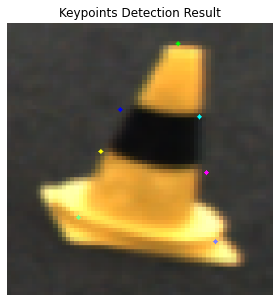

In [16]:
pt.fig = pt.figure(figsize=(5, 5))

pt.imshow(image)
pt.axis('off')
pt.title('Keypoints Detection Result')

Congratulations! You've finished all the content of this tutorial!
Hope you enjoy playing with the our object detection model. If you are interested,  please refer to our paper and GitHub Repo for further details.

## Reference
[1] Kieran Strobel, Sibo Zhu, Raphael Chang and Skanda Koppula.
**Accurate, Low-Latency Visual Perception for Autonomous Racing:Challenges, Mechanisms, and Practical Solutions**. In *IROS* 2020.
[[paper]](https://arxiv.org/abs/2007.13971), [[code]](https://github.com/cv-core/MIT-Driverless-CV-TrainingInfra).